# Junior Quant Test — Horse Racing


**Contents**  
- Q0: Data exploration (structure, missingness, correlation matrix + top correlations)  
- Q1: Peak age by `race_type_simple` (win rate, mean RPR)  
- Q2: 0-1 Normalised Horse, Jockey, and Trainer Ratings 
- Q3: Predictive model — per‑race softmax (multinomial logistic), an xgBoost model, and a KNN model
- Q4: Compare to Betfair Starting Price (BSP), overlay strategy, ROI, and significance

In [2]:
import sys

def in_pyodide():
    try:
        import pyodide  
        return True
    except Exception:
        return False

if in_pyodide():
    import piplite
    try:
        import pandas as pd  
    except Exception:
        await piplite.install(['pandas'])
    try:
        import matplotlib  
    except Exception:
        await piplite.install(['matplotlib'])

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import defaultdict

pd.set_option('display.max_columns', 100)

## Q0 — Load Data & Basic Exploration

We load the CSV, parse dates/times, and preview the structure. Then we:
1) Quantify missingness per column.  
2) Summarise numerics.  
3) Build a correlation matrix (numeric columns only) and list the top absolute correlations.


In [3]:
# ---- Config ----
DATA_PATH = 'test_dataset.csv'  # change if needed, e.g., '/mnt/data/test_dataset.csv'

# ---- Load ----
df = pd.read_csv(DATA_PATH)

# Parse date, time for chronological ops later
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# race_time standardisation
rt = pd.to_datetime(df['race_time'], format='%H:%M:%S', errors='coerce')
mask = rt.isna()
if mask.any():
    rt.loc[mask] = pd.to_datetime(df.loc[mask, 'race_time'], format='%H:%M', errors='coerce')
rt = rt.fillna(pd.Timestamp('1900-01-01 00:00:00'))
seconds = (rt.dt.hour * 3600 + rt.dt.minute * 60 + rt.dt.second).astype('int64')
df['_ts'] = df['date'].dt.normalize() + pd.to_timedelta(seconds, unit='s')

print(df.shape)
df.head(5)

(777549, 31)


,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,_ts
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95,2015-05-01 13:40:00
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61,2015-05-01 13:40:00
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36,2015-05-01 13:40:00
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70,2015-05-01 13:40:00
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53,2015-05-01 13:40:00


In [4]:
# Missingness (%)
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.to_frame('missing_%').head(20)

# This just checks to see whether we need to account for missing data and makes us think how me may do that

,missing_%
official_rating,26.186903
obs__top_speed,21.036488
obs__racing_post_rating,8.309701
obs__completion_time,6.140063
ltp_5min,0.197544
racecourse_country,0.000000
date,0.000000
race_type,0.000000
race_type_simple,0.000000
n_runners,0.000000


In [5]:
# Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].describe().T

# This simply gives us a basic idea of the kind of values we will be working around, some summarys are non-useful such as race_id however its insightful for rows such as age and obs_bsp

,count,mean,std,min,25%,50%,75%,max
race_id,777549.0,109715.692889,61586.714991,28.000000,59382.000000,92420.000000,162331.000000,215837.000000
race_distance,777549.0,2576.181522,1262.509887,1000.353600,1409.090400,2253.081600,3461.918400,6907.377600
n_runners,777549.0,10.922081,3.995936,2.000000,8.000000,11.000000,13.000000,40.000000
horse_id,777549.0,82528.762396,64900.547393,1.000000,27889.000000,69863.000000,137989.000000,311690.000000
age,777549.0,5.111508,2.318795,1.000000,3.000000,5.000000,7.000000,18.000000
official_rating,573933.0,84.482016,25.583146,1.000000,65.000000,80.000000,102.000000,177.000000
carried_weight,777549.0,62.940441,6.810474,43.544868,57.152639,60.327785,69.399633,81.193034
draw,777549.0,3.749681,4.408433,0.000000,0.000000,2.000000,7.000000,37.000000
jockey_id,777549.0,8641.737704,16411.299575,5.000000,982.000000,3885.000000,9613.000000,311367.000000
trainer_id,777549.0,557.279600,632.519600,1.000000,123.000000,405.000000,836.000000,11162.000000


In [6]:
# Correlation matrix (numeric)
corr = df[num_cols].corr(numeric_only=True)
# Top absolute correlations (excluding self)
pairs = []
for i, c1 in enumerate(num_cols):
    for j, c2 in enumerate(num_cols):
        if j <= i: 
            continue
        val = corr.loc[c1, c2]
        if not np.isnan(val):
            pairs.append((c1, c2, val, abs(val)))
pairs_sorted = sorted(pairs, key=lambda x: x[3], reverse=True)
top_corr = pd.DataFrame(pairs_sorted[:20], columns=['var1','var2','corr','|corr|'])
top_corr

# This gives us an idea on the top relationships variables have between each other 
# For example ratings and top speeds being positively linked is somewhat expected, and rating and weight being postively strongly linked is interesting

,var1,var2,corr,|corr|
0,race_distance,obs__completion_time,0.992167,0.992167
1,ltp_5min,obs__bsp,0.934715,0.934715
2,official_rating,obs__racing_post_rating,0.835460,0.835460
3,carried_weight,obs__completion_time,0.808010,0.808010
4,race_distance,carried_weight,0.792306,0.792306
5,obs__racing_post_rating,obs__top_speed,0.756827,0.756827
6,official_rating,carried_weight,0.739218,0.739218
7,race_distance,official_rating,0.665727,0.665727
8,official_rating,obs__completion_time,0.664746,0.664746
9,official_rating,obs__top_speed,0.638842,0.638842


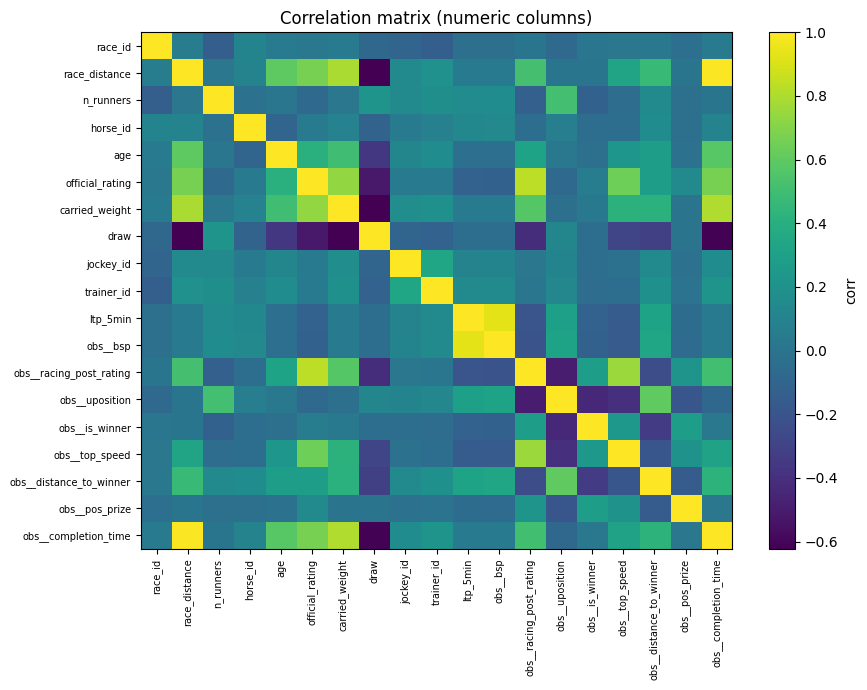

In [7]:
# Visualize correlation matrix 
plt.figure(figsize=(9,7))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.title('Correlation matrix (numeric columns)')
plt.colorbar(label='corr')
plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=7)
plt.yticks(range(len(num_cols)), num_cols, fontsize=7)
plt.tight_layout()
plt.show()

# This helps us see all the variable correlations in a more visual way, its intersting to see race distance being so postively linked with so many different variables, suggesting it plays a significant role in the outcomes and partcipants of the race

## Q1 — Peak Age by Race Type

**Idea:** For each `race_type_simple`, compute **win rate** and **mean RPR** by **age**.  
This reveals **peak performance age** (where win rate / RPR is highest).

In [8]:
# Ensure necessary columns exist
assert 'race_type_simple' in df.columns, "Missing 'race_type_simple'"
assert 'age' in df.columns, "Missing 'age'"
assert 'obs__is_winner' in df.columns, "Missing 'obs__is_winner'"
assert 'obs__racing_post_rating' in df.columns, "Missing 'obs__racing_post_rating'"

# Group by type+age
g = df.groupby(['race_type_simple','age'], dropna=True)
agg = g.agg(
    runs = ('obs__is_winner','count'),
    wins = ('obs__is_winner','sum'),
    mean_RPR = ('obs__racing_post_rating','mean')
).reset_index()
agg['win_rate'] = agg['wins'] / agg['runs']

# Peak by win_rate and by mean_RPR for each type
peaks = agg.sort_values(['race_type_simple','win_rate'], ascending=[True,False]).groupby('race_type_simple').head(1)
peaks_RPR = agg.sort_values(['race_type_simple','mean_RPR'], ascending=[True,False]).groupby('race_type_simple').head(1)

print("Peak age by WIN RATE:")
display(peaks[['race_type_simple','age','win_rate','runs']])

print("\nPeak age by MEAN RPR:")
display(peaks_RPR[['race_type_simple','age','mean_RPR','runs']])

# Its interesting to see the mismatch between the highest win rates and the mean RPR, which you would think would be tightly linked
# Its worth noting that due to the tiny sample size for the Flat AW and Hurdle in the Win Rate table, its diffcult to conclude anything with significance from these

Peak age by WIN RATE:


,race_type_simple,age,win_rate,runs
0,Chase,4,0.190317,599
27,Flat AW,15,0.142857,7
31,Flat Turf,3,0.115186,96479
58,Hurdle,16,0.166667,6



Peak age by MEAN RPR:


,race_type_simple,age,mean_RPR,runs
2,Chase,6,109.697951,15121
18,Flat AW,6,62.329951,15333
33,Flat Turf,5,72.013632,43157
48,Hurdle,6,94.704850,44887


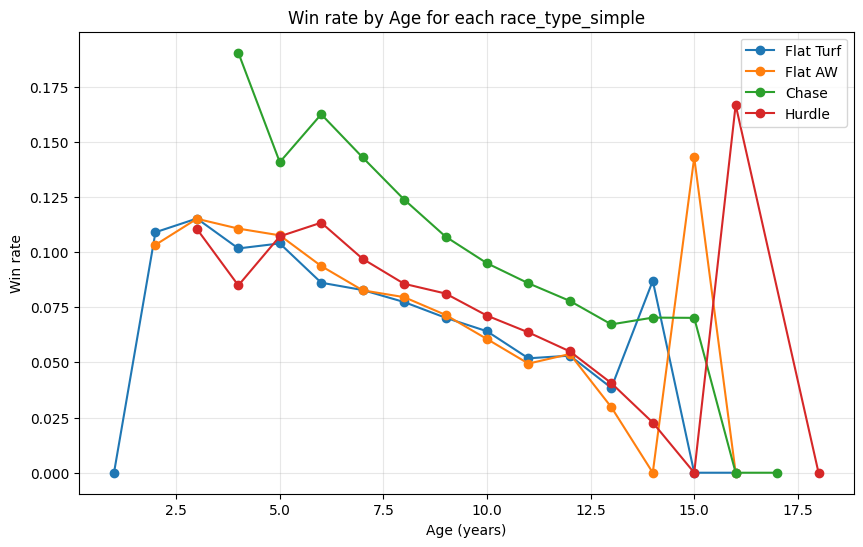

In [9]:
# Win rate vs age per race type
types = df['race_type_simple'].dropna().unique().tolist()
plt.figure(figsize=(10,6))
for t in types:
    sub = agg[agg['race_type_simple']==t].sort_values('age')
    plt.plot(sub['age'], sub['win_rate'], marker='o', label=t)
plt.xlabel('Age (years)')
plt.ylabel('Win rate')
plt.title('Win rate by Age for each race_type_simple')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Its interesting to see a steadily declining graph for all race types until they hit a certain age 14-15 where they peak again
# I'm thinking that this could be a result of younger horses being generally better however only the very best horses are still running at the high ages, which disproportionately represents the quality of older runners

## Q2 — Ratings (Horse, Jockey, Trainer)

We create past‑only ratings, all of which include a 'difficulty of the field' factor:
- Horse rating: mean of prior non‑missing RPR for that horse.  
- Jockey win rate: prior wins / prior rides for that jockey.  
- Trainer win rate**: prior wins / prior runners for that trainer.

If no prior (debutant), we fill with a **global mean** so the feature remains numeric and comparable.


In [10]:
# ============================================================
# HORSE PERFORMANCE RATING (no RPR in the horse score)
# Big-win bonus included; RPR used only for field strength
# Outputs:
#   field_strength, field_strength_pct, _fs_mult
#   horse_points (this race, 0..100)
#   horse_rating_prior_mean (leak-free prior mean)
#   horse_rating_prior_ewm  (leak-free prior EWMA)
# ============================================================

import numpy as np
import pandas as pd

# ---------- Checks ----------
req_ids = ['race_id','horse_id']
missing = [c for c in req_ids if c not in df.columns]
if missing:
    raise AssertionError(f"df is missing mandatory columns: {missing}")

# Prefer these if present
pos_candidates = ['obs__uposition','position','fin_pos','pos']
bd_candidates  = ['obs__distance_beaten','distance_beaten','dist_btn','obs__distance_to_winner']

def first_present(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

pos_col = first_present(pos_candidates)
bd_col  = first_present(bd_candidates)

# ---------- Copy and stable chronological order ----------
X = df.copy()

# Build timestamp columns if available
if 'date' in X.columns:
    X['date'] = pd.to_datetime(X['date'], errors='coerce')
else:
    X['date'] = pd.NaT

if 'race_time' in X.columns:
    rt = pd.to_datetime(X['race_time'], format='%H:%M:%S', errors='coerce')
    m  = rt.isna()
    if m.any():
        rt.loc[m] = pd.to_datetime(X.loc[m, 'race_time'], format='%H:%M', errors='coerce')
else:
    rt = pd.NaT

if isinstance(rt, pd.Series):
    secs = (rt.dt.hour.fillna(0).astype(int)*3600 +
            rt.dt.minute.fillna(0).astype(int)*60 +
            rt.dt.second.fillna(0).astype(int))
else:
    secs = pd.Series(0, index=X.index)

X['_ts'] = X['date'].fillna(pd.Timestamp('1900-01-01')) + pd.to_timedelta(secs, unit='s')
X = X.sort_values(['_ts','race_id'], kind='mergesort').reset_index(drop=True)

# ---------- Core race features ----------
# Field size
X['_n'] = X.groupby('race_id')['horse_id'].transform('count').astype('int64')

# Position as integer; fallbacks if needed
if pos_col is not None:
    X['_pos'] = pd.to_numeric(X[pos_col], errors='coerce')
else:
    if 'obs__is_winner' in X.columns:
        w = pd.to_numeric(X['obs__is_winner'], errors='coerce').fillna(0).astype(int)
        X['_pos'] = np.where(w == 1, 1, np.nan)

        if 'obs__bsp' in X.columns:
            def fill_pos(g):
                if g['_pos'].isna().all():
                    order = pd.to_numeric(g['obs__bsp'], errors='coerce')
                    return order.rank(method='first').astype(float)
                losers = g['_pos'].isna()
                order = pd.to_numeric(g.loc[losers, 'obs__bsp'], errors='coerce')
                g.loc[losers, '_pos'] = 1 + order.rank(method='first').astype(float)
                return g['_pos']
            X['_pos'] = X.groupby('race_id', group_keys=False).apply(fill_pos)
        else:
            def fill_pos_uniform(g):
                if g['_pos'].isna().all():
                    g['_pos'] = np.arange(1, len(g)+1)
                else:
                    losers = g['_pos'].isna()
                    g.loc[losers, '_pos'] = np.arange(2, 2 + losers.sum())
                return g['_pos']
            X['_pos'] = X.groupby('race_id', group_keys=False).apply(fill_pos_uniform)
    else:
        raise AssertionError("Need a finishing position column or obs__is_winner to infer positions.")

# Beaten distance
if bd_col is not None:
    X['_bd'] = pd.to_numeric(X[bd_col], errors='coerce')
else:
    X['_bd'] = np.where(X['_pos'] == 1, 0.0, np.nan)

BD_CAP = 30.0
X['_bd_cap'] = np.clip(X['_bd'], 0, BD_CAP)

# ---------- Field strength from RPR; not used in horse score directly ----------
if 'obs__racing_post_rating' in X.columns:
    rpr = pd.to_numeric(X['obs__racing_post_rating'], errors='coerce')
    fs_mean = X.groupby('race_id')[rpr.name].transform(lambda s: s.mean(skipna=True))
    X['field_strength'] = fs_mean.fillna(rpr.median(skipna=True))
else:
    X['field_strength'] = X['_n'].astype(float)

# Percentile and multiplier
race_fs = X.groupby('race_id')['field_strength'].first()
fs_pct = race_fs.rank(pct=True, method='average').to_dict()
X['field_strength_pct'] = X['race_id'].map(fs_pct).astype(float)

def fs_multiplier(p):
    grid_p = np.array([0.00, 0.25, 0.50, 0.75, 1.00], dtype=float)
    grid_m = np.array([0.85, 0.95, 1.00, 1.07, 1.15], dtype=float)
    return np.interp(p, grid_p, grid_m)

X['_fs_mult'] = fs_multiplier(X['field_strength_pct'])

# ---------- Winner margin and big-win bonus ----------
def add_winner_margin(g):
    d = pd.to_numeric(g.loc[g['_pos'] != 1, '_bd_cap'], errors='coerce')
    margin = d.min(skipna=True)
    g['_win_margin'] = np.where(g['_pos'] == 1, margin, np.nan)
    return g

X = X.groupby('race_id', group_keys=False).apply(add_winner_margin)

M_START   = 2.0     # lengths before bonus starts
M_CAP     = 12.0    # lengths at which bonus reaches max
BONUS_MAX = 0.08    # up to +0.08 added before multiplier

wm = pd.to_numeric(X['_win_margin'], errors='coerce')
frac = (wm - M_START) / max(M_CAP - M_START, 1e-9)
frac = np.clip(frac, 0.0, 1.0)
big_win_bonus = np.where(X['_pos'] == 1, BONUS_MAX * frac, 0.0)
big_win_bonus = np.nan_to_num(big_win_bonus, nan=0.0)

# ---------- Scores and per-race points ----------
W_POS, W_BD = 0.70, 0.30

# Position score: winner 1.0; last near 0.0; scaled by field size
pos_pct = (pd.to_numeric(X['_pos'], errors='coerce') - 1) / np.maximum(X['_n'] - 1, 1)
pos_score = 1.0 - pos_pct.clip(0, 1)

# Distance score: winner 1.0; farther behind → lower
bd_score = 1.0 - (X['_bd_cap'] / BD_CAP)
bd_score = bd_score.fillna(bd_score.median())

# Win/place bonuses
win_bonus   = (X['_pos'] == 1).astype(float) * 0.10
place_mask  = ((X['_n'] >= 8) & (X['_pos'] <= 3)) | ((X['_n'] < 8) & (X['_pos'] <= 2))
place_bonus = place_mask.astype(float) * 0.04

# Composite and multiplier
base   = (W_POS * pos_score + W_BD * bd_score + win_bonus + place_bonus + big_win_bonus)
scaled = np.clip(base, 0.0, 1.2) * X['_fs_mult']
X['horse_points'] = np.clip(scaled, 0.0, 1.0) * 100.0

# ---------- Leak-free prior ratings ----------
# Prior mean
grp_hp   = X.groupby('horse_id', sort=False)['horse_points']
cum_sum  = grp_hp.cumsum() - X['horse_points']
cum_cnt  = grp_hp.cumcount()
prior_mu = (cum_sum / cum_cnt.replace(0, np.nan)).astype(float)
X['horse_rating_prior_mean'] = prior_mu.fillna(X['horse_points'].mean())

# Prior EWMA via transform; shift first to avoid leakage
ALPHA = 0.4
X['horse_rating_prior_ewm'] = (
    X.groupby('horse_id')['horse_points']
     .transform(lambda s: s.shift(1).ewm(alpha=ALPHA, adjust=False).mean())
)
X['horse_rating_prior_ewm'] = X['horse_rating_prior_ewm'].fillna(X['horse_points'].mean())

# ---------- Output ----------
cols_out = [
    'race_id','horse_id','_n','_pos','_bd_cap',
    'field_strength','field_strength_pct','_fs_mult',
    '_win_margin','horse_points',
    'horse_rating_prior_mean','horse_rating_prior_ewm'
]
cols_out = [c for c in cols_out if c in X.columns]
horse_ratings = X[cols_out].copy()




C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\3499697920.py:130: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = X.groupby('race_id', group_keys=False).apply(add_winner_margin)


Using rating column: horse_rating_prior_ewm

Top 20 Horses by Current Rating:


,horse_id,current_rating,horse_name
0,194155,100.0,Ohnodonttakemehome
1,91883,100.0,Gorytus
2,166860,100.0,Dubai Quest
3,201764,100.0,Siskin
4,165462,100.0,Sprinter Sacre
5,123724,100.0,Altesse
6,152264,100.0,Beautiful Illusion
7,47694,100.0,Impulsive Dancer
8,115363,100.0,Touchy Feely
9,37719,100.0,War Envoy


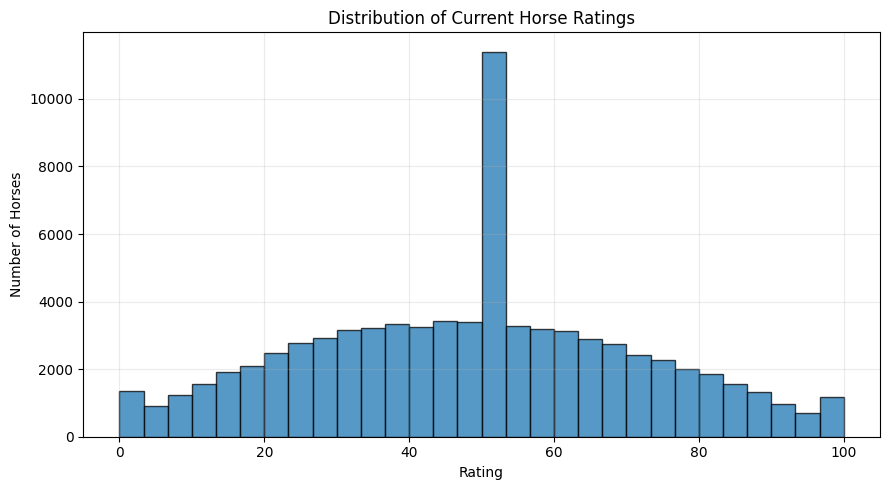

Decile breakdown of current ratings:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\2404788120.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('decile')


,decile,count,mean_rating,min_rating,max_rating
0,"(-0.001, 18.048]",7791,9.844785,0.000000,18.045687
1,"(18.048, 28.154]",7790,23.359010,18.050445,28.154064
2,"(28.154, 36.404]",7791,32.342996,28.154375,36.403977
3,"(36.404, 44.245]",7790,40.313294,36.404850,44.244417
4,"(44.245, 51.889]",7791,48.064255,44.245581,51.889441
5,"(51.889, 53.05]",9207,52.979447,51.893546,53.050101
6,"(53.05, 59.61]",6373,56.282874,53.051094,59.608558
7,"(59.61, 68.384]",7791,63.868506,59.610705,68.383081
8,"(68.384, 79.61]",7790,73.666449,68.385560,79.607970
9,"(79.61, 100.0]",7791,88.451719,79.611867,100.000000


Summary statistics of current ratings:


,current_rating
count,77905.000000
mean,48.857222
std,22.599730
min,0.000000
25%,32.376257
50%,51.889441
75%,63.804065
max,100.000000


In [11]:
# ============================================================
# OUTPUT: Top-20 horses + rating distribution (robust)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Preconditions ----
if 'X' not in globals():
    raise RuntimeError("Expected the rating step to define DataFrame X. Please run the rating cell first.")

# Candidate rating columns in preference order
rating_candidates = ['horse_rating_prior_ewm', 'horse_rating_prior_mean', 'horse_points']
rating_col = next((c for c in rating_candidates if c in X.columns), None)
if rating_col is None:
    raise RuntimeError(f"None of the expected rating columns are present: {rating_candidates}")

print(f"Using rating column: {rating_col}")

# Optional horse-name column
name_col = next((c for c in ['horse_name','name','horse','Horse'] if c in X.columns), None)

# ---- 1) Latest rating per horse (chronological-safe) ----
if '_ts' in X.columns:
    X_sorted = X.sort_values(['_ts', 'race_id']).reset_index(drop=True)
else:
    # Fallback to stable order as in X
    X_sorted = X.reset_index(drop=True)

keep_cols = ['horse_id', rating_col]
if name_col:
    keep_cols.append(name_col)

latest = (
    X_sorted.groupby('horse_id', as_index=False)
            .tail(1)[keep_cols]
    .rename(columns={rating_col: 'current_rating'})
)

# ---- 2) Top 20 table ----
top20 = latest.sort_values('current_rating', ascending=False).head(20)
print("\nTop 20 Horses by Current Rating:")
display(top20.reset_index(drop=True))

# ---- 3) Frequency histogram of current ratings (one point per horse) ----
vals = latest['current_rating'].astype(float).to_numpy()
plt.figure(figsize=(9,5))
plt.hist(vals, bins=30, edgecolor='black', alpha=0.75)
plt.title('Distribution of Current Horse Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Horses')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ---- 4) Decile table (structure of ratings) ----
# Create decile bins and count horses per bin
deciles = pd.qcut(latest['current_rating'], q=10, duplicates='drop')
decile_table = (latest.assign(decile=deciles)
                        .groupby('decile')
                        .agg(count=('horse_id','count'),
                             mean_rating=('current_rating','mean'),
                             min_rating=('current_rating','min'),
                             max_rating=('current_rating','max'))
                        .reset_index())

print("Decile breakdown of current ratings:")
display(decile_table)

# ---- 5) Quick summary stats ----
print("Summary statistics of current ratings:")
display(latest['current_rating'].describe().to_frame('current_rating'))


In [12]:
import numpy as np
import pandas as pd

# Chronological order ("final" means most recent)
df = df.sort_values(['_ts','race_id'], kind='mergesort').reset_index(drop=True)

# Ensure helper columns for the formulas (only created if missing)
if '_won' not in df.columns:
    df['_won'] = pd.to_numeric(df.get('obs__is_winner', 0), errors='coerce').fillna(0).astype(int)

if '_pos' not in df.columns:
    df['_pos'] = pd.to_numeric(df.get('obs__uposition', np.nan), errors='coerce')

if '_perf' not in df.columns:
    # relative finishing percentile: 1=winner, 0=last; guard for n_runners==1
    nr = pd.to_numeric(df.get('n_runners', np.nan), errors='coerce')
    df['_perf'] = 1 - ((df['_pos'] - 1) / (nr - 1).clip(lower=1))
    df.loc[~np.isfinite(df['_perf']), '_perf'] = 0.0

if '_placed' not in df.columns:
    df['_placed'] = ((df['_pos'] <= 3) | (df['_perf'] >= 0.75)).astype(int)

# Build jockey_win_rate if missing (70% win-rate + 30% perf, prior-only)
if 'jockey_win_rate' not in df.columns:
    gJ = df.groupby('jockey_id', sort=False)
    prior_wins_j  = gJ['_won'].cumsum() - df['_won']
    prior_rides_j = gJ.cumcount()
    prior_perf_j  = gJ['_perf'].cumsum() - df['_perf']
    jw = 0.7 * (prior_wins_j / prior_rides_j.replace(0, np.nan)) \
       + 0.3 * (prior_perf_j / prior_rides_j.replace(0, np.nan))
    df['jockey_win_rate'] = jw.fillna(jw.mean(skipna=True)).astype('float64')

# Build trainer_win_rate if missing (60% win-rate + 40% placed, prior-only)
if 'trainer_win_rate' not in df.columns:
    gT = df.groupby('trainer_id', sort=False)
    prior_wins_t   = gT['_won'].cumsum() - df['_won']
    prior_runs_t   = gT.cumcount()
    prior_places_t = gT['_placed'].cumsum() - df['_placed']
    tw = 0.6 * (prior_wins_t / prior_runs_t.replace(0, np.nan)) \
       + 0.4 * (prior_places_t / prior_runs_t.replace(0, np.nan))
    df['trainer_win_rate'] = tw.fillna(tw.mean(skipna=True)).astype('float64')

# Extract the FINAL (most recent) rating per jockey
jockey_final = (
    df.sort_values(['jockey_id','_ts'])
      .groupby('jockey_id', as_index=False)
      .tail(1)[['jockey_id','jockey_win_rate']]
      .reset_index(drop=True)
)
jockey_ranked = jockey_final.sort_values('jockey_win_rate', ascending=False).reset_index(drop=True)
jockey_ranked['rank'] = np.arange(1, len(jockey_ranked)+1)

print("🏇 Top 20 jockeys by final rating (jockey_win_rate):")
display(jockey_ranked.head(20))

# Extract the FINAL (most recent) rating per trainer
trainer_final = (
    df.sort_values(['trainer_id','_ts'])
      .groupby('trainer_id', as_index=False)
      .tail(1)[['trainer_id','trainer_win_rate']]
      .reset_index(drop=True)
)
trainer_ranked = trainer_final.sort_values('trainer_win_rate', ascending=False).reset_index(drop=True)
trainer_ranked['rank'] = np.arange(1, len(trainer_ranked)+1)

print("🏠 Top 20 trainers by final rating (trainer_win_rate):")
display(trainer_ranked.head(20))



🏇 Top 20 jockeys by final rating (jockey_win_rate):


,jockey_id,jockey_win_rate,rank
0,190413,1.000000,1
1,30194,1.000000,2
2,183473,1.000000,3
3,29787,1.000000,4
4,58654,0.702381,5
5,69696,0.670000,6
6,27328,0.653439,7
7,67687,0.625000,8
8,26954,0.624432,9
9,136523,0.623317,10


🏠 Top 20 trainers by final rating (trainer_win_rate):


,trainer_id,trainer_win_rate,rank
0,7337,1.000000,1
1,7380,1.000000,2
2,6251,1.000000,3
3,8562,1.000000,4
4,7459,1.000000,5
5,7442,1.000000,6
6,2244,1.000000,7
7,6202,1.000000,8
8,3107,1.000000,9
9,5654,0.700000,10


## Q3 — Predictive Model (Per‑Race Softmax with NumPy)

We build a simple **multinomial logistic** model:
- Each horse gets a **score** \( s_i = w^\top x_i \).  
- The per‑race **win probability** is the **softmax**:  
  \( p_i = \frac{e^{s_i}}{\sum_{j \in \text{same race}} e^{s_j}} \).  
- We minimize **cross‑entropy** (negative log‑likelihood) via gradient descent.

**Features used (known pre‑race only):**
- `official_rating`, `horse_rating`, `jockey_win_rate`, `trainer_win_rate`, `age`, `carried_weight`, `race_distance`, `n_runners`, `draw`
- One‑hots for `race_type_simple` and a coarse `going_clean` bin (e.g., Good/Firm/Standard vs Soft/Heavy)

> We split **chronologically**: earlier dates → train, later dates → test (avoids look‑ahead).

In [13]:
# ===== PRELUDE: ensure engineered features exist (no leakage) =====
import pandas as pd
import numpy as np

df = df.copy()

# Robust winner flag, used for jockey/trainer win-rates 
if 'obs__is_winner' in df.columns:
    w = pd.to_numeric(df['obs__is_winner'], errors='coerce').fillna(0)
    df['_won'] = (w > 0).astype(int)
elif 'obs__uposition' in df.columns:
    df['_won'] = (pd.to_numeric(df['obs__uposition'], errors='coerce') == 1).astype(int)
else:
    raise AssertionError("Need obs__is_winner or obs__uposition to define winners.")

# Build a chronological sort key (no format guessing) 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
rt = pd.to_datetime(df['race_time'], format='%H:%M:%S', errors='coerce')
mask = rt.isna()
if mask.any():
    rt.loc[mask] = pd.to_datetime(df.loc[mask, 'race_time'], format='%H:%M', errors='coerce')
rt = rt.fillna(pd.Timestamp('1900-01-01 00:00:00'))
secs = (rt.dt.hour*3600 + rt.dt.minute*60 + rt.dt.second).astype('int64')
df['_ts'] = df['date'].dt.normalize() + pd.to_timedelta(secs, unit='s')
df = df.sort_values(['_ts','race_id'], kind='mergesort').reset_index(drop=True)

# --- HORSE RATING: average prior RPR per horse (non-missing only) ---
# Try to find a source RPR column if 'horse_rating' not already present
if 'horse_rating' not in df.columns:
    rpr_source = None
    for c in ['obs__racing_post_rating','Horse_Rating','RPR','rpr']:
        if c in df.columns:
            rpr_source = c
            break

    if rpr_source is not None and 'horse_id' in df.columns:
        rpr = pd.to_numeric(df[rpr_source], errors='coerce')
        rpr_filled = rpr.fillna(0.0).astype('float64')
        gh = df.groupby('horse_id', sort=False)
        prev_sum = gh[rpr_filled.name].cumsum() - rpr_filled
        prev_cnt = gh[rpr.notna().name].cumsum() - rpr.notna().astype('int64')
        horse_rating = (prev_sum / prev_cnt.replace(0, np.nan)).astype('float64')
        df['horse_rating'] = horse_rating.fillna(horse_rating.mean(skipna=True))
    else:
        # Fallback: if no RPR or horse_id, at least create the column so your pipeline runs
        df['horse_rating'] = np.nan

# JOCKEY WIN-RATE: prior wins / rides per jockey
if 'jockey_win_rate' not in df.columns and 'jockey_id' in df.columns:
    gj = df.groupby('jockey_id', sort=False)
    prev_wins_j = gj['_won'].cumsum() - df['_won']
    prev_rides_j = gj.cumcount()
    jw = (prev_wins_j / prev_rides_j.replace(0, np.nan)).astype('float64')
    df['jockey_win_rate'] = jw.fillna(jw.mean(skipna=True))
elif 'jockey win rate' in df.columns and 'jockey_win_rate' not in df.columns:
    # Normalise a spaced name to underscored
    df = df.rename(columns={'jockey win rate':'jockey_win_rate'})

# TRAINER WIN-RATE: prior wins / runs per trainer 
if 'trainer_win_rate' not in df.columns and 'trainer_id' in df.columns:
    gt = df.groupby('trainer_id', sort=False)
    prev_wins_t = gt['_won'].cumsum() - df['_won']
    prev_runs_t = gt.cumcount()
    tw = (prev_wins_t / prev_runs_t.replace(0, np.nan)).astype('float64')
    df['trainer_win_rate'] = tw.fillna(tw.mean(skipna=True))

# ---- Prepare features ----
def make_going_bin(s):
    if pd.isna(s):
        return 'Unknown'
    s = str(s).lower()
    aw = ['standard', 'std', 'std/slow', 'standard/slow', 'slow']
    softish = ['good to soft','soft','soft/heavy','heavy','yielding']
    firmish = ['firm','good to firm']
    if any(k in s for k in aw): return 'AW'
    if any(k in s for k in softish): return 'Soft/Heavy'
    if any(k in s for k in firmish): return 'Firm/GoodFirm'
    if 'good' in s: return 'Good'
    return s.title()

df['going_bin'] = df['going_clean'].apply(make_going_bin).astype('category')
df['race_type_simple'] = df['race_type_simple'].astype('category')

base_cols = ['official_rating','horse_rating','jockey_win_rate','trainer_win_rate',
             'age','carried_weight','race_distance','n_runners','draw']

for c in base_cols:
    if c not in df.columns:
        raise AssertionError(f"Missing feature {c}")

# Fill numerics
for c in base_cols:
    if df[c].dtype.kind not in 'biufc':
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].fillna(df[c].median())

# One-hot categorical (limited columns to avoid explosion)
X_cat = pd.get_dummies(df[['race_type_simple','going_bin']], drop_first=True)

# Final design matrix
X_num = df[base_cols].reset_index(drop=True)
X = pd.concat([X_num, X_cat.reset_index(drop=True)], axis=1).astype('float64')

# Target: one winner per race
y = df['obs__is_winner'].values
race_ids = df['race_id'].values

# Standardize numerics for stable training
mu = X.mean(axis=0).values
sd = X.std(axis=0).replace(0, 1.0).values
X_std = (X.values - mu) / sd

feature_names = X.columns.tolist()
X_std.shape, len(feature_names)

((777549, 14), 14)

In [14]:
# ---- Chronological split ----
# 80% earliest rows -> train, 20% latest -> test, while respecting time order
n = len(df)
cut = int(n * 0.8)

train_idx = np.arange(0, cut)
test_idx  = np.arange(cut, n)

Xtr, ytr = X_std[train_idx], y[train_idx]
Xte, yte = X_std[test_idx], y[test_idx]
race_tr = race_ids[train_idx]
race_te = race_ids[test_idx]

# For fast grouping (race to indices within split)
def group_indices(race_array):
    idx_by_race = defaultdict(list)
    for i, r in enumerate(race_array):
        idx_by_race[r].append(i)
    return list(idx_by_race.values())

groups_tr = group_indices(race_tr)
groups_te = group_indices(race_te)

len(groups_tr), len(groups_te)

(65400, 16409)

In [15]:
# ============================================================
# Multinomial-by-normalisation using XGBoost (binary per runner)
# ============================================================
!pip install xgboost scikit-learn

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# --- check prerequisites ---
need = ['Xtr','Xte','ytr','yte','groups_tr','groups_te']
missing = [n for n in need if n not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}")

# ---------- helpers ----------
def normalize_per_group(p, groups):
    p = p.astype(float).copy()
    for idxs in groups:
        idxs = np.asarray(idxs, dtype=int)
        s = p[idxs].sum()
        p[idxs] = p[idxs]/s if s > 0 else 1/len(idxs)
    return p

def brier(y, p): return float(np.mean((y.astype(float) - p)**2))

def logloss_per_race(y, p, groups):
    total, cnt = 0.0, 0
    for idxs in groups:
        idxs = np.asarray(idxs, int)
        y_g, p_g = y[idxs], p[idxs]
        if y_g.sum() == 1:
            total += -np.log(p_g[np.argmax(y_g)] + 1e-12)
            cnt += 1
    return total / max(cnt, 1)

# ---------- build & train ----------
pos = float((ytr == 1).sum())
neg = float((ytr == 0).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=0,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100,
)

eval_set = [(Xtr, ytr), (Xte, yte)]
clf.fit(Xtr, ytr, eval_set=eval_set, verbose=False)

# ---------- predict & normalise per race ----------
p_tr_raw = clf.predict_proba(Xtr)[:, 1]
p_te_raw = clf.predict_proba(Xte)[:, 1]
p_tr = normalize_per_group(p_tr_raw, groups_tr)
p_te = normalize_per_group(p_te_raw, groups_te)

# ---------- metrics ----------
print(f"Train Brier   : {brier(ytr, p_tr):.4f}")
print(f"Test  Brier   : {brier(yte, p_te):.4f}")
print(f"Train LogLoss  (per race): {logloss_per_race(ytr, p_tr, groups_tr):.4f}")
print(f"Test  LogLoss  (per race): {logloss_per_race(yte, p_te, groups_te):.4f}")
print(f"Best iteration : {clf.best_iteration}")

# ---------- feature importance ----------
imp = clf.get_booster().get_score(importance_type='gain')
imp_df = pd.DataFrame(list(imp.items()), columns=['feature','gain']).sort_values('gain', ascending=False)
print("\nTop 10 features by gain:")
display(imp_df.head(10))



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\kierb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Train Brier   : 0.0828
Test  Brier   : 0.0870
Train LogLoss  (per race): 1.7709
Test  LogLoss  (per race): 1.9198
Best iteration : 1999

Top 10 features by gain:


,feature,gain
1,f1,67.705612
7,f7,55.766220
3,f3,36.987869
4,f4,31.264750
2,f2,29.361734
11,f11,27.658438
0,f0,26.023390
10,f10,22.519548
9,f9,21.555193
5,f5,21.171581


In [16]:
# ============================================================
# Predict probabilities and normalise per race (XGBoost model)
# ============================================================

import numpy as np
import pandas as pd

# ---- Make sure these exist ----
need = ['clf','Xtr','Xte','ytr','yte','groups_tr','groups_te']
missing = [n for n in need if n not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}")

# ---- 1. Predict raw probabilities (of being the winner) ----
p_tr_raw = clf.predict_proba(Xtr)[:, 1]
p_te_raw = clf.predict_proba(Xte)[:, 1]

# ---- 2. Normalise per race ----
def normalize_per_race(p, groups):
    """Ensures probabilities sum to 1 per race."""
    p_norm = p.copy().astype(float)
    for idxs in groups:
        idxs = np.asarray(idxs, dtype=int)
        total = np.sum(p_norm[idxs])
        if total > 0:
            p_norm[idxs] /= total
        else:
            p_norm[idxs] = 1.0 / len(idxs)  # fallback to uniform
    return p_norm

p_tr = normalize_per_race(p_tr_raw, groups_tr)
p_te = normalize_per_race(p_te_raw, groups_te)

# ---- 3. Define per-race evaluation metrics ----
def brier(y, p):
    """Brier score = mean squared error of predicted probs."""
    return float(np.mean((y - p)**2))

def logloss_per_race(y, p, groups):
    """Negative log-likelihood of winners per race."""
    total, cnt = 0.0, 0
    for idxs in groups:
        idxs = np.asarray(idxs, dtype=int)
        y_g, p_g = y[idxs], p[idxs]
        if y_g.sum() == 1:
            total += -np.log(p_g[np.argmax(y_g)] + 1e-12)
            cnt += 1
    return total / max(cnt, 1)

# ---- 4. Evaluate ----
print(f"Train Brier: {brier(ytr, p_tr):.4f}")
print(f"Test  Brier: {brier(yte, p_te):.4f}")
print(f"Train LogLoss (per race): {logloss_per_race(ytr, p_tr, groups_tr):.4f}")
print(f"Test  LogLoss (per race): {logloss_per_race(yte, p_te, groups_te):.4f}")

# ---- 5. Optional: sanity check sum of probs per race ----
for n, grp in enumerate(groups_te[:5], 1):
    total = np.sum(p_te[grp])
    print(f"Race {n}: sum of predicted probs = {total:.4f}")


Train Brier: 0.0828
Test  Brier: 0.0870
Train LogLoss (per race): 1.7709
Test  LogLoss (per race): 1.9198
Race 1: sum of predicted probs = 1.0000
Race 2: sum of predicted probs = 1.0000
Race 3: sum of predicted probs = 1.0000
Race 4: sum of predicted probs = 1.0000
Race 5: sum of predicted probs = 1.0000


In [17]:
## Did have a KNN model too however this took far too long to run everytime and performed somewhat similarly to the XGBoost model

## Q4 — Compare vs Market (Betfair SP)

We compare our model’s probabilities to market implied probabilities:
- Market implied: \( q = 1/\text{BSP} \).  
- **Overlay strategy:** Bet if \( p_{model} > q \).  
- **ROI:** average net return per bet (zero commission).  
- **Significance:** z‑test for mean ROI = 0 (approx., large‑sample).

XGBoost value-only strategies (commission=0.0%)


,All overlays,Top overlay / race
bets,86782.0000,16409.0000
wins,6352.0000,1210.0000
hit_rate,0.0732,0.0737
roi,0.1879,0.4240
total_pnl,16308.3360,6957.3750
avg_edge,0.0632,0.1259
avg_bsp_winners,16.2296,19.3111


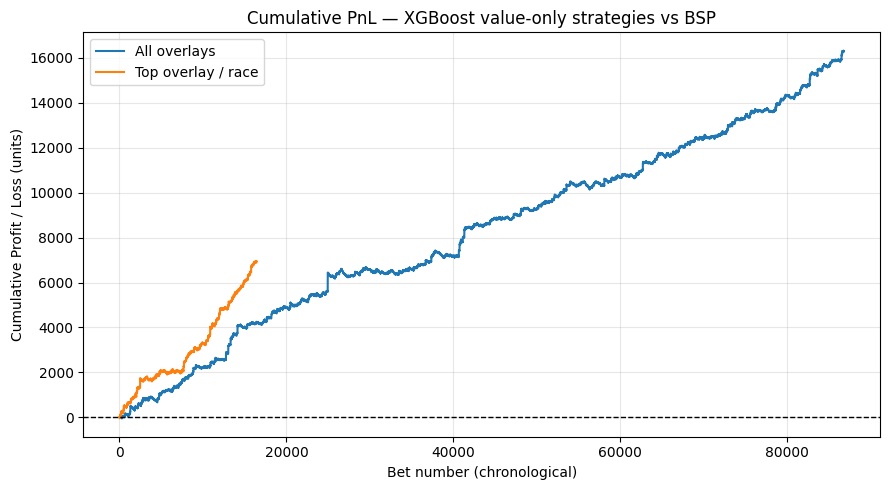

In [18]:
# ============================================================
# XGBoost probabilities vs BSP — Positive-EV betting test (pos-aligned)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
COMMISSION = 0.0    # e.g. 0.02 for 2% commission
STAKE = 1.0

# ---- Required variables ----
need = ['df','p_te','yte']
missing = [n for n in need if n not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}")

# ---- 1) Build the unfiltered TEST slice in the SAME order used for Xte/yte ----
# Preferred: use test_races to pull test rows in race order
if 'test_races' in globals():
    base = df.loc[df['race_id'].isin(test_races), ['race_id','obs__bsp','_ts']].copy()
# Or: use an explicit boolean mask
elif 'test_mask' in globals():
    base = df.loc[np.asarray(test_mask, dtype=bool), ['race_id','obs__bsp','_ts']].copy()
else:
    # Fallback: assume last len(yte) rows are test (least ideal)
    base = df.iloc[-len(yte):][['race_id','obs__bsp','_ts']].copy()

# Positional key to align with p_te / yte BEFORE any filtering
base = base.reset_index().rename(columns={'index':'df_index'})
base['pos'] = np.arange(len(base), dtype=int)

# ---- 2) Wrap model outputs with the SAME positional key ----
if len(p_te) != len(base):
    # If lengths differ, trim to the overlapping front (keeps chronological order)
    n = min(len(p_te), len(base))
    p_df = pd.DataFrame({'pos': np.arange(n, dtype=int), '_p': p_te[:n], '_y': yte[:n]})
    base = base.loc[base['pos'] < n].copy()
else:
    p_df = pd.DataFrame({'pos': np.arange(len(p_te), dtype=int), '_p': p_te, '_y': yte})

# ---- 3) Merge by position, THEN filter BSP validity ----
work = base.merge(p_df, on='pos', how='inner')
work['_bsp'] = pd.to_numeric(work['obs__bsp'], errors='coerce')
work = work[np.isfinite(work['_bsp']) & (work['_bsp'] > 0)].copy()

# ---- 4) EV computation and selection (bet when EV > 0) ----
net_profit_if_win = (work['_bsp'] - 1.0) * (1.0 - COMMISSION)                 # profit per 1u on win after commission
work['_p_thresh'] = 1.0 / (1.0 + net_profit_if_win)                            # EV>0  ⇔  p > 1/(1 + net_profit)
work['_is_value'] = work['_p'] > work['_p_thresh']
work['_EV'] = work['_p'] * net_profit_if_win - (1.0 - work['_p'])

# ---- Strategy A: bet ALL overlays (flat 1u) ----
A = work[work['_is_value']].copy()
A['ret'] = np.where(A['_y'] == 1, net_profit_if_win.loc[A.index], -1.0)

# ---- Strategy B: per race, take ONLY the strongest overlay (max p - threshold) ----
B = (work[work['_is_value']]
     .assign(edge=lambda d: d['_p'] - d['_p_thresh'])
     .sort_values(['race_id','edge'], ascending=[True, False])
     .groupby('race_id', as_index=False)
     .head(1)
     .copy())
B['ret'] = np.where(B['_y'] == 1, net_profit_if_win.loc[B.index], -1.0)

# ---- 5) Summaries ----
def summarize(df_, name):
    if len(df_) == 0:
        return pd.Series({'bets':0,'wins':0,'hit_rate':np.nan,'roi':np.nan,'total_pnl':np.nan,
                          'avg_edge':np.nan,'avg_bsp_winners':np.nan}, name=name)
    return pd.Series({
        'bets': len(df_),
        'wins': int(df_['_y'].sum()),
        'hit_rate': df_['_y'].mean(),
        'roi': df_['ret'].mean(),
        'total_pnl': df_['ret'].sum(),
        'avg_edge': (df_['_p'] - df_['_p_thresh']).mean(),
        'avg_bsp_winners': df_.loc[df_['_y']==1, '_bsp'].mean() if (df_['_y']==1).any() else np.nan
    }, name=name)

summary = pd.concat([
    summarize(A, 'All overlays'),
    summarize(B, 'Top overlay / race')
], axis=1)

print(f"XGBoost value-only strategies (commission={COMMISSION:.1%})")
display(summary.round(4))

# ---- 6) Cumulative PnL plot (chronological if _ts available) ----
plt.figure(figsize=(9,5))
if len(A):
    A_plot = A.sort_values(['_ts','race_id']).reset_index(drop=True)
    plt.plot(np.arange(1, len(A_plot)+1), A_plot['ret'].cumsum(), label='All overlays')
if len(B):
    B_plot = B.sort_values(['_ts','race_id']).reset_index(drop=True)
    plt.plot(np.arange(1, len(B_plot)+1), B_plot['ret'].cumsum(), label='Top overlay / race')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Bet number (chronological)')
plt.ylabel('Cumulative Profit / Loss (units)')
plt.title('Cumulative PnL — XGBoost value-only strategies vs BSP')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
# ================================================
# Overlay betting (aligned by position, no mismatch)
# ================================================
import numpy as np
import pandas as pd

COMMISSION = 0.0  # set e.g. 0.02 for 2% commission

# --- 1) Build the unfiltered TEST slice in the SAME order as yte/p_te ---
# Prefer exact indices if you saved them
if 'test_index' in globals():
    base = df.loc[test_index, ['race_id','obs__bsp']].copy()
elif 'test_races' in globals():
    base = df.loc[df['race_id'].isin(test_races), ['race_id','obs__bsp']].copy()
elif 'test_mask' in globals():
    base = df.loc[np.asarray(test_mask, dtype=bool), ['race_id','obs__bsp']].copy()
else:
    # Fallback: assume last len(yte) rows are test (least ideal, but avoids shape errors)
    base = df.iloc[-len(yte):][['race_id','obs__bsp']].copy()

# Add a positional key so we can align BEFORE filtering any rows
base = base.reset_index(drop=False).rename(columns={'index':'df_index'})
base['pos'] = np.arange(len(base), dtype=int)

# Wrap model outputs with the same positional key
n = min(len(base), len(p_te), len(yte))  # overlap length
p_frame = pd.DataFrame({'pos': np.arange(n, dtype=int),
                        '_p': p_te[:n].astype(float),
                        '_y': yte[:n].astype(int)})

# Merge by position, then clean BSP
work = base.merge(p_frame, on='pos', how='inner')
work['_bsp'] = pd.to_numeric(work['obs__bsp'], errors='coerce')
work = work[np.isfinite(work['_bsp']) & (work['_bsp'] > 0)].copy()

# --- 2) Compute market implied prob and overlay condition ---
# After commission, net win profit per 1u stake is (BSP-1)*(1-commission)
net_win = (work['_bsp'] - 1.0) * (1.0 - COMMISSION)
q_te   = 1.0 / work['_bsp']                      # market implied probability (no overround adj)
p_th   = 1.0 / (1.0 + net_win)                   # break-even prob threshold
overlay = work['_p'] > p_th                      # +EV bet

# --- 3) Returns: + (BSP-1)*(1-comm) on win; -1 on loss (only where we bet) ---
wins = work['_y'] == 1
ret = np.zeros(len(work), dtype=float)
ret[overlay & wins]  = net_win[overlay & wins].to_numpy()
ret[overlay & ~wins] = -1.0

# --- 4) Metrics ---
n_bets = int(overlay.sum())
total_return = float(ret[overlay].sum()) if n_bets else 0.0
roi = float(ret[overlay].mean()) if n_bets else 0.0
hit = float(wins[overlay].mean()) if n_bets else np.nan
avg_bsp_win = float(work.loc[overlay & wins, '_bsp'].mean()) if (overlay & wins).any() else np.nan
avg_edge = float((work['_p'] - p_th)[overlay].mean()) if n_bets else np.nan

print(f"Overlay bets: {n_bets}")
print(f"Total return: {total_return:.2f} (on {n_bets} stakes)")
print(f"ROI per bet: {roi:.4f}")
print(f"Hit rate: {hit:.2%}")
print(f"Avg (p - threshold): {avg_edge:.4f}")
print(f"Avg BSP on winners: {avg_bsp_win:.2f}")


Overlay bets: 86782
Total return: 16308.34 (on 86782 stakes)
ROI per bet: 0.1879
Hit rate: 7.32%
Avg (p - threshold): 0.0632
Avg BSP on winners: 16.23


In [20]:
# Rough significance: test mean(ret) = 0 for overlay bets (CLT z-test)
if n_bets > 1:
    x = ret[overlay]
    m = x.mean()
    s = x.std(ddof=1)
    se = s / math.sqrt(len(x))
    z = m / (se + 1e-12)
    # two-sided p-value under N(0,1)
    from math import erf, sqrt
    pval = 2 * (1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    print(f"z = {z:.2f}, p ≈ {pval:.3f}")
else:
    print("Not enough overlay bets for a significance check.")

z = 7.35, p ≈ 0.000


Average winner BSP by going × distance bin:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\3079199515.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = winners.groupby(['_going','_dist_bin'])


,_going,_dist_bin,avg_bsp,median_bsp,n_winners
0,Firm/GoodFirm,≤1200,8.365557,5.300,1713
1,Firm/GoodFirm,1200–1600,9.086545,5.610,3473
2,Firm/GoodFirm,1600–2400,8.408839,5.080,3582
3,Firm/GoodFirm,2400–3200,7.665342,4.820,1085
4,Firm/GoodFirm,3200–4200,7.218682,4.265,760
5,Firm/GoodFirm,4200–5200,7.387825,4.740,343
6,Firm/GoodFirm,5200–7200,8.859730,3.900,37
7,Firm/GoodFirm,>7200,NaN,NaN,0
8,Good,≤1200,9.406884,5.740,4024
9,Good,1200–1600,10.004832,5.860,11579



Pivot table (rows=going, cols=distance bin, values=average BSP):


_dist_bin,≤1200,1200–1600,1600–2400,2400–3200,3200–4200,4200–5200,5200–7200,>7200
_going,,,,,,,,
Firm/GoodFirm,8.365557,9.086545,8.408839,7.665342,7.218682,7.387825,8.859730,NaN
Good,9.406884,10.004832,9.558652,8.900173,8.877358,8.725337,10.677598,NaN
Soft/Heavy,9.532212,11.055436,9.684122,8.044970,9.410746,9.333398,11.180096,NaN


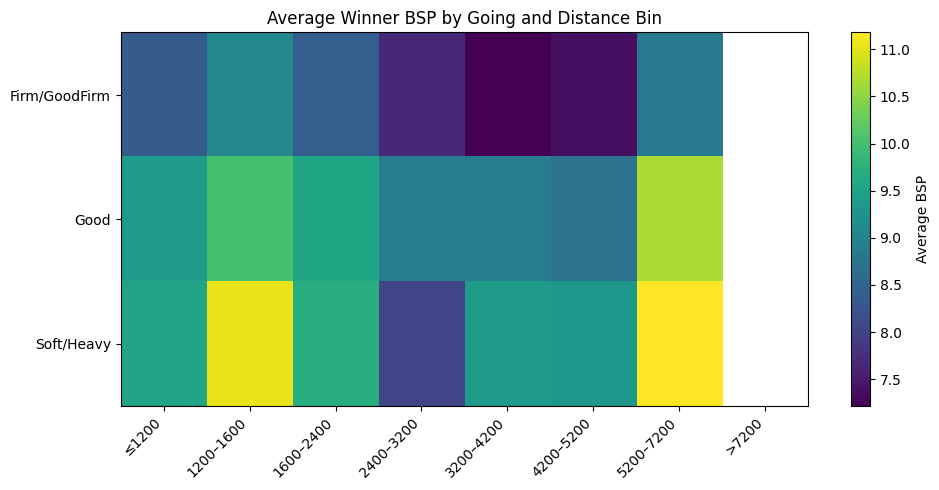


Cells with at least 20 winners:


_dist_bin,≤1200,1200–1600,1600–2400,2400–3200,3200–4200,4200–5200,5200–7200
_going,,,,,,,
Firm/GoodFirm,8.365557,9.086545,8.408839,7.665342,7.218682,7.387825,8.859730
Good,9.406884,10.004832,9.558652,8.900173,8.877358,8.725337,10.677598
Soft/Heavy,9.532212,11.055436,9.684122,8.044970,9.410746,9.333398,11.180096


In [21]:
# Average winner odds by going and distance bin
# Requirements: pandas, numpy, matplotlib; df must contain:
# 'obs__bsp' (Betfair Starting Price decimal odds), 'obs__is_winner' (0/1),
# 'going_clean' (string), 'race_distance' (meters)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure required columns exist
required_cols = ['obs__bsp','obs__is_winner','going_clean','race_distance']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Dataframe is missing required columns: {missing}")

# 2) Clean numeric fields
df['_bsp'] = pd.to_numeric(df['obs__bsp'], errors='coerce')
df['_dist'] = pd.to_numeric(df['race_distance'], errors='coerce')

# 3) Define a simple going bin function to group similar surfaces
def going_bin(s):
    if pd.isna(s):
        return 'Unknown'
    s = str(s).lower()
    aw = ['standard','std','std/slow','standard/slow','slow']
    softish = ['good to soft','soft','soft/heavy','heavy','yielding']
    firmish = ['firm','good to firm']
    if any(k in s for k in aw): return 'AW'
    if any(k in s for k in softish): return 'Soft/Heavy'
    if any(k in s for k in firmish): return 'Firm/GoodFirm'
    if 'good' in s: return 'Good'
    return s.title()

df['_going'] = df['going_clean'].apply(going_bin)

# 4) Distance bins, tweak as you like
bins = [0, 1200, 1600, 2400, 3200, 4200, 5200, 7200, np.inf]
labels = ['≤1200','1200–1600','1600–2400','2400–3200','3200–4200','4200–5200','5200–7200','>7200']
df['_dist_bin'] = pd.cut(df['_dist'], bins=bins, labels=labels, include_lowest=True)

# 5) Filter to winners with valid BSP and distance
winners = df[(df['obs__is_winner'] == 1) & np.isfinite(df['_bsp']) & np.isfinite(df['_dist'])].copy()

# 6) Group and compute average odds, plus counts for context
grp = winners.groupby(['_going','_dist_bin'])
summary = grp['_bsp'].agg(avg_bsp='mean', median_bsp='median', n_winners='count').reset_index()

# 7) Pivot for a grid view, average BSP per cell
pivot_avg = summary.pivot(index='_going', columns='_dist_bin', values='avg_bsp').sort_index()

# 8) Show tidy tables
print("Average winner BSP by going × distance bin:")
display(summary.sort_values(['_going','_dist_bin']))

print("\nPivot table (rows=going, cols=distance bin, values=average BSP):")
display(pivot_avg)

# 9) Optional heatmap with matplotlib only
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot_avg.values, aspect='auto', interpolation='nearest')
ax.set_xticks(range(pivot_avg.shape[1]))
ax.set_yticks(range(pivot_avg.shape[0]))
ax.set_xticklabels(pivot_avg.columns.astype(str), rotation=45, ha='right')
ax.set_yticklabels(pivot_avg.index.astype(str))
ax.set_title('Average Winner BSP by Going and Distance Bin')
fig.colorbar(im, ax=ax, label='Average BSP')
plt.tight_layout()
plt.show()

# 10) Optional: filter for robust cells only (e.g., at least 20 winners in a cell)
min_n = 20
robust = summary[summary['n_winners'] >= min_n]
pivot_robust = robust.pivot(index='_going', columns='_dist_bin', values='avg_bsp').sort_index()
print(f"\nCells with at least {min_n} winners:")
display(pivot_robust)

Band = middle 20% of winner BSPs; commission=0.0%


,segment,status,n_races,n_winners_for_band,low_thr,high_thr,n_bets,wins,hit_rate,roi,total_pnl,avg_bsp,avg_bsp_win
0,Firm/GoodFirm | >5200,insufficient winners,7,7,NaN,NaN,0,0,NaN,NaN,0.000,NaN,NaN
1,Good | 3200–5200,ok,4056,4056,4.0200,6.060,4114,814,0.197861,-0.020329,-83.632,5.031329,4.951312
2,Good | 1600–3200,ok,3456,3456,4.3400,6.400,3641,702,0.192804,0.017926,65.269,5.357118,5.279585
3,Good | ≤1600,ok,3157,3156,4.6800,6.880,3476,635,0.182681,0.026104,90.737,5.733388,5.616909
4,Soft/Heavy | 3200–5200,ok,2445,2445,4.1700,6.600,2755,503,0.182577,-0.050509,-139.152,5.334557,5.200493
5,Firm/GoodFirm | ≤1600,ok,869,869,4.5500,6.652,960,174,0.181250,-0.009240,-8.870,5.544904,5.466264
6,Soft/Heavy | 1600–3200,ok,716,716,4.5000,6.600,748,149,0.199198,0.093783,70.150,5.521497,5.490940
7,Firm/GoodFirm | 1600–3200,ok,772,772,3.8940,5.662,703,154,0.219061,0.037368,26.270,4.731336,4.735519
8,Soft/Heavy | ≤1600,ok,549,549,5.1120,7.240,581,109,0.187608,0.133632,77.640,6.136110,6.042569
9,Soft/Heavy | >5200,ok,81,81,5.5000,8.600,138,17,0.123188,-0.171667,-23.690,7.001884,6.724118



ROI by going × distance bin:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:160: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_roi = results.pivot_table(index='going', columns='dist_bin', values='roi', aggfunc='first').sort_index().sort_index(axis=1)
C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:161: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_pnl = results.pivot_table(index='going', columns='dist_bin', values='total_pnl', aggfunc='first').sort_index().sort_index(axis=1)


dist_bin,≤1600,1600–3200,3200–5200,>5200
going,,,,
Firm/GoodFirm,-0.009240,0.037368,0.100191,NaN
Good,0.026104,0.017926,-0.020329,0.406176
Soft/Heavy,0.133632,0.093783,-0.050509,-0.171667



Total PnL by going × distance bin:


dist_bin,≤1600,1600–3200,3200–5200,>5200
going,,,,
Firm/GoodFirm,-8.870,26.270,11.522,0.00
Good,90.737,65.269,-83.632,55.24
Soft/Heavy,77.640,70.150,-139.152,-23.69



Total PnL by Going:


,total_pnl
going,
Good,127.614
Firm/GoodFirm,28.922
Soft/Heavy,-15.052



Total PnL by Distance Bin:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_distance = results.groupby('dist_bin')['total_pnl'].sum().sort_values(ascending=False)


,total_pnl
dist_bin,
1600–3200,161.689
≤1600,159.507
>5200,31.550
3200–5200,-211.262



Overall Total PnL Across All Going × Distance Bins: 141.48 units

Weighted ROI by Going:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['roi'], weights=x['n_bets'].clip(lower=1)))


,weighted_roi
going,
Good,0.011227
Soft/Heavy,-0.003565
Firm/GoodFirm,NaN



Weighted ROI by Distance:


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:188: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roi_by_distance = (results.groupby('dist_bin')
C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\563193887.py:189: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['roi'], weights=x['n_bets'].clip(lower=1)))


,weighted_roi
dist_bin,
≤1600,0.031793
1600–3200,0.031754
3200–5200,-0.030249
>5200,NaN


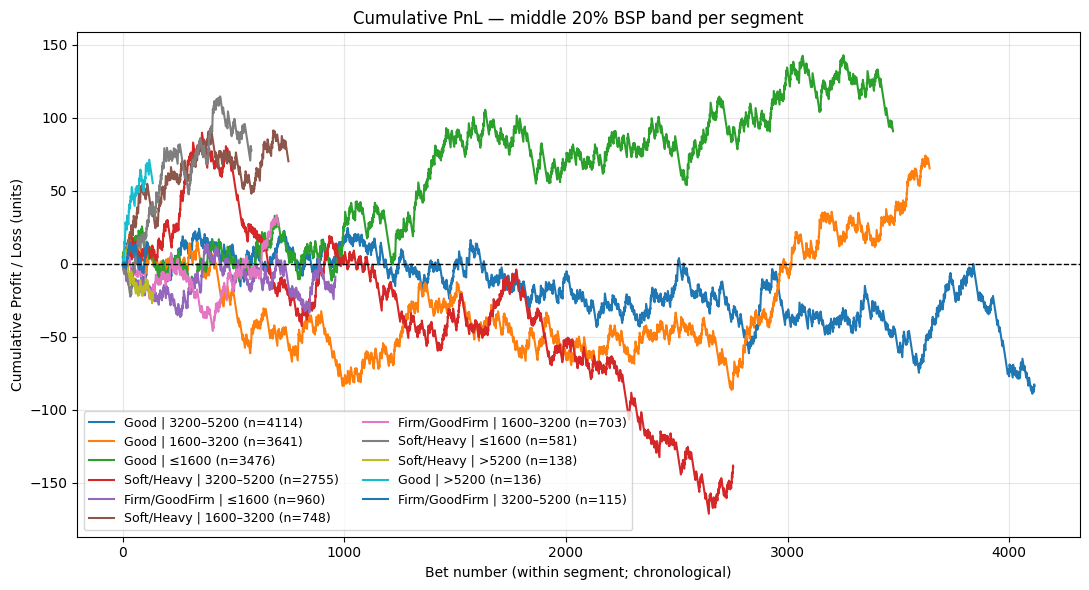

In [22]:
# ============================================================
# Evaluate middle-X% BSP band for EVERY going × distance bin
# on the TEST set: table + multi-line cumulative PnL plot
# Using wider distance bins (half the previous count)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Editable parameters ----------
BAND_PERCENT    = 0.20   # middle 30% band; e.g., 0.30 gives 35th–65th percentiles
COMMISSION      = 0.00   # e.g., 0.02 for 2% Betfair commission
MIN_WINNERS_PCT = 10     # require at least this many winners in a bin to compute percentiles
MAX_LINES_PLOT  = 12     # plot top N segments by bet count; set None to plot all
INCLUDE_EDGES   = True   # include odds that equal the percentile bounds

# ---------- Requirements ----------
req = ['obs__bsp','obs__is_winner','going_clean','race_distance','race_id']
miss = [c for c in req if c not in df.columns]
if miss:
    raise ValueError(f"df missing required columns: {miss}")

# ---------- Going and distance bins (create or reuse) ----------
if '_going' not in df.columns:
    def going_bin(s):
        if pd.isna(s):
            return 'Unknown'
        s = str(s).lower()
        if any(k in s for k in ['standard','std','std/slow','standard/slow','slow']):
            return 'AW'
        if any(k in s for k in ['good to soft','soft','soft/heavy','heavy','yielding']):
            return 'Soft/Heavy'
        if any(k in s for k in ['firm','good to firm']):
            return 'Firm/GoodFirm'
        if 'good' in s:
            return 'Good'
        return s.title()
    df['_going'] = df['going_clean'].apply(going_bin)

if '_dist' not in df.columns:
    df['_dist'] = pd.to_numeric(df['race_distance'], errors='coerce')

# Wider distance bins; half as many as before
bins   = [0, 1600, 3200, 5200, np.inf]
labels = ['≤1600','1600–3200','3200–5200','>5200']
df['_dist_bin'] = pd.cut(df['_dist'], bins=bins, labels=labels, include_lowest=True)

# ---------- Build TEST slice ----------
if 'test_races' in globals():
    test_df = df.loc[df['race_id'].isin(test_races)].copy()
elif 'test_mask' in globals():
    test_df = df.loc[np.asarray(test_mask, dtype=bool)].copy()
elif 'yte' in globals():
    test_df = df.iloc[-len(yte):].copy()  # fallback when explicit split not stored
else:
    raise RuntimeError("Provide test_races, test_mask, or yte to define the test split.")

# Clean fields
test_df['_bsp'] = pd.to_numeric(test_df['obs__bsp'], errors='coerce')
test_df['_y']   = pd.to_numeric(test_df['obs__is_winner'], errors='coerce').fillna(0).astype(int)

# ---------- Helper to compute band thresholds and returns for a segment ----------
def evaluate_segment(seg, band=BAND_PERCENT, include_edges=True, commission=0.0):
    """Return metrics dict and per-bet cumulative curve for one going × distance segment."""
    winners = seg[(seg['_y'] == 1) & np.isfinite(seg['_bsp'])]
    if len(winners) < MIN_WINNERS_PCT:
        return None, None

    lower_q = (1.0 - band) / 2.0
    upper_q = 1.0 - lower_q
    low_thr  = winners['_bsp'].quantile(lower_q)
    high_thr = winners['_bsp'].quantile(upper_q)
    if not np.isfinite(low_thr) or not np.isfinite(high_thr) or low_thr >= high_thr:
        return None, None

    if include_edges:
        mask_band = (seg['_bsp'] >= low_thr) & (seg['_bsp'] <= high_thr)
    else:
        mask_band = (seg['_bsp'] >  low_thr) & (seg['_bsp'] <  high_thr)
    bets = seg[np.isfinite(seg['_bsp']) & mask_band].copy()
    if bets.empty:
        return {
            'n_winners_for_band': len(winners),
            'low_thr': low_thr, 'high_thr': high_thr,
            'n_races': seg['race_id'].nunique(),
            'n_bets': 0, 'wins': 0,
            'hit_rate': np.nan, 'roi': np.nan, 'total_pnl': 0.0,
            'avg_bsp': np.nan, 'avg_bsp_win': np.nan
        }, np.array([])

    net_win = (bets['_bsp'] - 1.0) * (1.0 - commission)
    bets['ret'] = np.where(bets['_y'] == 1, net_win, -1.0)

    if '_ts' in bets.columns:
        bets = bets.sort_values(['_ts','race_id'])
    else:
        bets = bets.sort_values('race_id')
    curve = bets['ret'].cumsum().to_numpy()

    n_bets   = len(bets)
    wins     = int(bets['_y'].sum())
    hit_rate = wins / n_bets if n_bets else np.nan
    roi      = bets['ret'].mean() if n_bets else np.nan
    pnl      = bets['ret'].sum() if n_bets else 0.0
    avg_bsp  = bets['_bsp'].mean() if n_bets else np.nan
    avg_bspw = bets.loc[bets['_y']==1, '_bsp'].mean() if (bets['_y']==1).any() else np.nan

    return {
        'n_winners_for_band': len(winners),
        'low_thr': low_thr, 'high_thr': high_thr,
        'n_races': seg['race_id'].nunique(),
        'n_bets': n_bets, 'wins': wins,
        'hit_rate': hit_rate, 'roi': roi, 'total_pnl': pnl,
        'avg_bsp': avg_bsp, 'avg_bsp_win': avg_bspw
    }, curve

# ---------- Evaluate all going × distance bins ----------
rows = []
curves = {}  # key -> cumulative array
for g in sorted(test_df['_going'].dropna().unique()):
    # iterate in fixed distance order
    for dlab in pd.Categorical(test_df['_dist_bin']).categories:
        seg = test_df[(test_df['_going'] == g) & (test_df['_dist_bin'] == dlab)].copy()
        if seg.empty:
            continue
        metrics, curve = evaluate_segment(seg, BAND_PERCENT, INCLUDE_EDGES, COMMISSION)
        key = f"{g} | {dlab}"
        if metrics is None:
            rows.append({'segment': key, 'status': 'insufficient winners',
                         'n_winners_for_band': int(seg['_y'].sum()),
                         'n_races': seg['race_id'].nunique(),
                         'n_bets': 0, 'wins': 0, 'hit_rate': np.nan,
                         'roi': np.nan, 'total_pnl': 0.0,
                         'low_thr': np.nan, 'high_thr': np.nan,
                         'avg_bsp': np.nan, 'avg_bsp_win': np.nan})
            continue
        metrics.update({'segment': key, 'status': 'ok'})
        rows.append(metrics)
        curves[key] = curve

results = pd.DataFrame(rows)
cols = ['segment','status','n_races','n_winners_for_band','low_thr','high_thr',
        'n_bets','wins','hit_rate','roi','total_pnl','avg_bsp','avg_bsp_win']
results = results.reindex(columns=cols)

# ---------- Print main table ----------
print(f"Band = middle {int(BAND_PERCENT*100)}% of winner BSPs; commission={COMMISSION:.1%}")
results_print = results.sort_values(['status','n_bets','total_pnl'], ascending=[True, False, False]).reset_index(drop=True)
display(results_print)

# ---------- Split 'segment' into going and distance columns ----------
parts = results['segment'].str.split(r' \| ', n=1, expand=True)
results = results.assign(going=parts[0], dist_bin=parts[1])

# preserve the new wider distance-bin order
dist_order = ['≤1600','1600–3200','3200–5200','>5200']
results['dist_bin'] = pd.Categorical(results['dist_bin'], categories=dist_order, ordered=True)

# ---------- Pivot tables ----------
pivot_roi = results.pivot_table(index='going', columns='dist_bin', values='roi', aggfunc='first').sort_index().sort_index(axis=1)
pivot_pnl = results.pivot_table(index='going', columns='dist_bin', values='total_pnl', aggfunc='first').sort_index().sort_index(axis=1)

print("\nROI by going × distance bin:")
display(pivot_roi)

print("\nTotal PnL by going × distance bin:")
display(pivot_pnl)

# ---------- Aggregates by going, by distance, and overall ----------
total_by_going = results.groupby('going')['total_pnl'].sum().sort_values(ascending=False)
print("\nTotal PnL by Going:")
display(total_by_going.to_frame('total_pnl'))

total_by_distance = results.groupby('dist_bin')['total_pnl'].sum().sort_values(ascending=False)
print("\nTotal PnL by Distance Bin:")
display(total_by_distance.to_frame('total_pnl'))

overall_total_pnl = results['total_pnl'].sum()
print(f"\nOverall Total PnL Across All Going × Distance Bins: {overall_total_pnl:.2f} units")

# Weighted ROI by going and distance; weights are number of bets in each bin
roi_by_going = (results.groupby('going')
                        .apply(lambda x: np.average(x['roi'], weights=x['n_bets'].clip(lower=1)))
                        .sort_values(ascending=False))
print("\nWeighted ROI by Going:")
display(roi_by_going.to_frame('weighted_roi'))

roi_by_distance = (results.groupby('dist_bin')
                           .apply(lambda x: np.average(x['roi'], weights=x['n_bets'].clip(lower=1)))
                           .sort_values(ascending=False))
print("\nWeighted ROI by Distance:")
display(roi_by_distance.to_frame('weighted_roi'))

# ---------- One plot: cumulative PnL lines for many segments ----------
plot_keys = sorted(curves.keys(), key=lambda k: len(curves[k]), reverse=True)
if isinstance(MAX_LINES_PLOT, int):
    plot_keys = plot_keys[:MAX_LINES_PLOT]

plt.figure(figsize=(11,6))
for k in plot_keys:
    y = curves[k]
    if len(y) == 0:
        continue
    x = np.arange(1, len(y)+1)
    plt.plot(x, y, label=f"{k} (n={len(y)})")
plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.xlabel('Bet number (within segment; chronological)')
plt.ylabel('Cumulative Profit / Loss (units)')
plt.title(f'Cumulative PnL — middle {int(BAND_PERCENT*100)}% BSP band per segment')
if plot_keys:
    plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Best band size (by total PnL):
  Band percent: 0.200  (20.0%)
  Total PnL:    141.48 units
  Bets placed:  17367


,band_%,total_pnl,n_bets,avg_return_per_bet,var_return,std_return
0,5.0,62.400,4441,0.014051,4.282128,2.069330
1,10.0,101.862,8615,0.011824,4.296371,2.072769
2,15.0,59.078,12964,0.004557,4.318545,2.078111
3,20.0,141.484,17367,0.008147,4.396120,2.096693
4,25.0,-4.595,21979,-0.000209,4.444233,2.108135
5,30.0,132.170,26411,0.005004,4.561027,2.135656
6,35.0,111.346,31135,0.003576,4.680922,2.163544
7,40.0,-182.923,36102,-0.005067,4.778184,2.185906
8,45.0,-142.592,41005,-0.003477,4.950610,2.224997
9,50.0,-444.775,46589,-0.009547,5.136433,2.266370


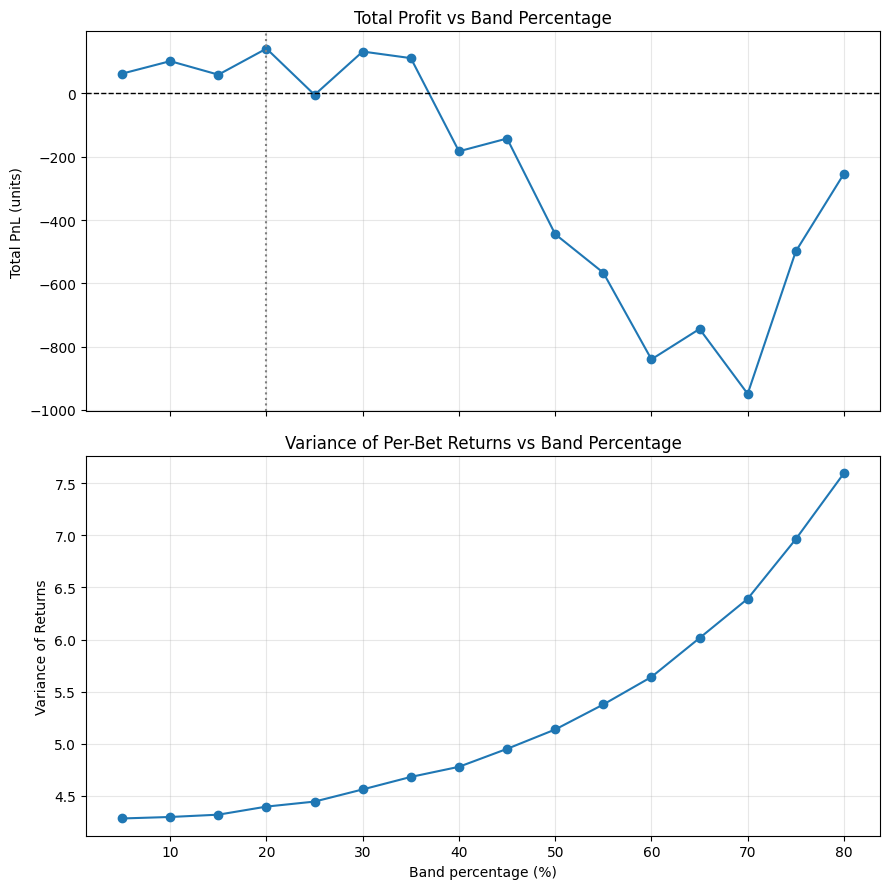

In [23]:
# ============================================================
# Optimise BAND_PERCENT to maximise overall profit on TEST set
# Also record return variance at each band level
# Plots: (1) Total PnL vs band %  (2) Variance vs band %
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- Editable parameters ----------
COMMISSION       = 0.00                 # e.g., 0.02 for 2% commission
INCLUDE_EDGES    = True                 # include odds exactly at the bounds
MIN_WINNERS_PCT  = 10                   # min winners per segment to define percentiles
BAND_GRID        = np.linspace(0.05, 0.80, 16)  # 5%..80% in equal steps
# Wider distance bins (as per your latest setup)
DIST_BINS        = [0, 1600, 3200, 5200, np.inf]
DIST_LABELS      = ['≤1600','1600–3200','3200–5200','>5200']

# --------- Requirements ----------
need_cols = ['obs__bsp','obs__is_winner','going_clean','race_distance','race_id']
miss = [c for c in need_cols if c not in df.columns]
if miss:
    raise ValueError(f"df is missing required columns: {miss}")

# --------- Ensure helper columns exist ----------
if '_going' not in df.columns:
    def going_bin(s):
        if pd.isna(s): return 'Unknown'
        s = str(s).lower()
        if any(k in s for k in ['standard','std','std/slow','standard/slow','slow']): return 'AW'
        if any(k in s for k in ['good to soft','soft','soft/heavy','heavy','yielding']): return 'Soft/Heavy'
        if any(k in s for k in ['firm','good to firm']): return 'Firm/GoodFirm'
        if 'good' in s: return 'Good'
        return s.title()
    df['_going'] = df['going_clean'].apply(going_bin)

if '_dist' not in df.columns:
    df['_dist'] = pd.to_numeric(df['race_distance'], errors='coerce')

if '_dist_bin' not in df.columns:
    df['_dist_bin'] = pd.cut(df['_dist'], bins=DIST_BINS, labels=DIST_LABELS, include_lowest=True)

# --------- Build TEST slice ----------
if 'test_races' in globals():
    test_df = df.loc[df['race_id'].isin(test_races)].copy()
elif 'test_mask' in globals():
    test_df = df.loc[np.asarray(test_mask, dtype=bool)].copy()
elif 'yte' in globals():
    test_df = df.iloc[-len(yte):].copy()  # fallback
else:
    raise RuntimeError("Provide test_races, test_mask, or yte to define the test split.")

# Clean fields
test_df['_bsp'] = pd.to_numeric(test_df['obs__bsp'], errors='coerce')
test_df['_y']   = pd.to_numeric(test_df['obs__is_winner'], errors='coerce').fillna(0).astype(int)

# --------- Helper: returns array for one segment at a given band ----------
def returns_for_segment_at_band(seg: pd.DataFrame, band: float, commission: float, include_edges: bool):
    """
    Return: np.array of returns (+(BSP-1)*(1-c) on wins; -1 on losses) for all bets
            selected by the middle 'band' of winner-BSPs in this segment.
    """
    winners = seg[(seg['_y'] == 1) & np.isfinite(seg['_bsp'])]
    if len(winners) < MIN_WINNERS_PCT:
        return np.array([])

    lower_q = (1.0 - band) / 2.0
    upper_q = 1.0 - lower_q
    low_thr  = winners['_bsp'].quantile(lower_q)
    high_thr = winners['_bsp'].quantile(upper_q)
    if not np.isfinite(low_thr) or not np.isfinite(high_thr) or low_thr >= high_thr:
        return np.array([])

    if include_edges:
        mask_band = (seg['_bsp'] >= low_thr) & (seg['_bsp'] <= high_thr)
    else:
        mask_band = (seg['_bsp'] >  low_thr) & (seg['_bsp'] <  high_thr)

    bets = seg[np.isfinite(seg['_bsp']) & mask_band]
    if bets.empty:
        return np.array([])

    net_win = (bets['_bsp'] - 1.0) * (1.0 - commission)
    ret = np.where(bets['_y'] == 1, net_win, -1.0)
    return ret.astype(float)

# --------- Sweep bands; aggregate across all segments ----------
band_rows = []
goings = sorted(test_df['_going'].dropna().unique())
dist_cats = pd.Categorical(test_df['_dist_bin']).categories

for band in BAND_GRID:
    all_returns = []
    for g in goings:
        for dlab in dist_cats:
            seg = test_df[(test_df['_going'] == g) & (test_df['_dist_bin'] == dlab)]
            if seg.empty:
                continue
            ret = returns_for_segment_at_band(seg, band, COMMISSION, INCLUDE_EDGES)
            if ret.size:
                all_returns.append(ret)

    if len(all_returns):
        all_returns = np.concatenate(all_returns)
        n_bets  = int(all_returns.size)
        total   = float(all_returns.sum())
        mean    = float(all_returns.mean())
        var     = float(np.var(all_returns, ddof=1)) if n_bets > 1 else np.nan  # sample variance
        std     = float(np.sqrt(var)) if np.isfinite(var) else np.nan
    else:
        n_bets = 0
        total  = 0.0
        mean   = np.nan
        var    = np.nan
        std    = np.nan

    band_rows.append({
        'band_percent': band,
        'band_%': round(band*100, 1),
        'total_pnl': total,
        'n_bets': n_bets,
        'avg_return_per_bet': mean,
        'var_return': var,
        'std_return': std
    })

opt_df = pd.DataFrame(band_rows).sort_values('band_%').reset_index(drop=True)

# --------- Report best band by total PnL ---------
if opt_df['total_pnl'].notna().any():
    best_idx = opt_df['total_pnl'].idxmax()
    best_row = opt_df.loc[best_idx]
    print("Best band size (by total PnL):")
    print(f"  Band percent: {best_row['band_percent']:.3f}  ({best_row['band_%']:.1f}%)")
    print(f"  Total PnL:    {best_row['total_pnl']:.2f} units")
    print(f"  Bets placed:  {int(best_row['n_bets'])}")
else:
    print("No valid bands produced any bets; check data availability or MIN_WINNERS_PCT.")

# --------- Show table with variance ----------
display(opt_df[['band_%','total_pnl','n_bets','avg_return_per_bet','var_return','std_return']])

# --------- Plot: Total PnL vs band %, and Variance vs band % ----------
fig, ax = plt.subplots(2, 1, figsize=(9,9), sharex=True)

# (1) Profit curve
ax[0].plot(opt_df['band_%'], opt_df['total_pnl'], marker='o')
ax[0].axhline(0, color='black', linewidth=1, linestyle='--')
if opt_df['total_pnl'].notna().any():
    ax[0].axvline(best_row['band_%'], color='grey', linestyle=':')
ax[0].set_ylabel('Total PnL (units)')
ax[0].set_title('Total Profit vs Band Percentage')

# (2) Variance curve (of per-bet returns)
ax[1].plot(opt_df['band_%'], opt_df['var_return'], marker='o')
ax[1].set_xlabel('Band percentage (%)')
ax[1].set_ylabel('Variance of Returns')
ax[1].set_title('Variance of Per-Bet Returns vs Band Percentage')

for a in ax:
    a.grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [24]:
# Based on this I would say 5%-20% inclusive is our ideal range about the median BSP winners for their respective category as it reduces variance and has good ROI potential, albeit close to 0.

### Non‑Obvious Relationships (Quick Digs)

A few subtle patterns to inspect:
- **Pct of winners who were rated highest pre-race**
- **Going vs average speed:** Compute `race_distance / obs__completion_time` (m/s) for winners to see how ground affects speed.


In [25]:
import pandas as pd
import numpy as np

# === CONFIG ===
RATING_COL = 'horse_rating'  # change if your pre-race rating column has a different name

# --- 1) Build a robust winner flag ---
w = df.copy()

if 'obs__is_winner' in w.columns:
    win_raw = pd.to_numeric(w['obs__is_winner'], errors='coerce')
    w['_won'] = (win_raw.fillna(0).astype(float) > 0).astype(int)
elif 'obs__uposition' in w.columns:
    up = pd.to_numeric(w['obs__uposition'], errors='coerce')
    w['_won'] = (up == 1).astype(int)
else:
    raise ValueError("Need obs__is_winner or obs__uposition to identify winners.")

# Keep only races with exactly one winner
winners_per_race = w.groupby('race_id')['_won'].sum()
valid_single_winner_races = winners_per_race[winners_per_race == 1].index
w = w[w['race_id'].isin(valid_single_winner_races)].copy()

# --- 2) Prepare rating and compute per-race max rating (ties allowed) ---
w['_rating'] = pd.to_numeric(w[RATING_COL], errors='coerce')

# Drop races where ALL ratings are NaN (cannot decide a highest rating)
race_has_any_rating = w.groupby('race_id')['_rating'].transform(lambda s: s.notna().any())
w = w[race_has_any_rating].copy()

# Per-race maximum rating (ignoring NaNs)
race_max = w.groupby('race_id')['_rating'].transform(np.nanmax)
w['_is_top_rated'] = (w['_rating'] == race_max)

# --- 3) Among winners, count how many are top-rated (ties count as top) ---
winners = w[w['_won'] == 1].copy()

num_top_winning = int(winners['_is_top_rated'].sum())
denom = len(winners)  # number of races considered (exactly one winner & at least one non-NaN rating)

pct = (num_top_winning / denom * 100.0) if denom > 0 else np.nan

print(f"Races evaluated (one winner, at least one non-NaN rating): {denom}")
print(f"Winners who were highest-rated (ties count): {num_top_winning}")
print(f"Percentage of winners that were the highest-rated pre-race: {pct:.2f}%")

Races evaluated (one winner, at least one non-NaN rating): 81808
Winners who were highest-rated (ties count): 6185
Percentage of winners that were the highest-rated pre-race: 7.56%


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\448090350.py:32: FutureWarning: The provided callable <function nanmax at 0x000002C0F925A700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  race_max = w.groupby('race_id')['_rating'].transform(np.nanmax)


In [26]:
import pandas as pd
import numpy as np

# --- CONFIG ---
BSP_COL = 'obs__bsp'  # column name for Betfair Starting Price

# --- 1) Build robust winner flag ---
w = df.copy()

if 'obs__is_winner' in w.columns:
    win_raw = pd.to_numeric(w['obs__is_winner'], errors='coerce')
    w['_won'] = (win_raw.fillna(0).astype(float) > 0).astype(int)
elif 'obs__uposition' in w.columns:
    up = pd.to_numeric(w['obs__uposition'], errors='coerce')
    w['_won'] = (up == 1).astype(int)
else:
    raise ValueError("Need obs__is_winner or obs__uposition to identify winners.")

# Keep only races with exactly one winner
winners_per_race = w.groupby('race_id')['_won'].sum()
valid_races = winners_per_race[winners_per_race == 1].index
w = w[w['race_id'].isin(valid_races)].copy()

# --- 2) Prepare BSP and compute per-race minimum (ties allowed) ---
w['_bsp'] = pd.to_numeric(w[BSP_COL], errors='coerce')

# Drop races where all BSPs are NaN or nonpositive
race_has_valid_bsp = w.groupby('race_id')['_bsp'].transform(lambda s: np.isfinite(s).any() and (s > 0).any())
w = w[race_has_valid_bsp].copy()

# Per-race minimum BSP (favourite odds)
race_min_bsp = w.groupby('race_id')['_bsp'].transform(np.nanmin)
w['_is_bsp_fav'] = (w['_bsp'] == race_min_bsp)

# --- 3) Among winners, count how many were BSP favourites ---
winners = w[w['_won'] == 1].copy()

num_fav_winners = int(winners['_is_bsp_fav'].sum())
denom = len(winners)  # number of races considered

pct = (num_fav_winners / denom * 100.0) if denom > 0 else np.nan

print(f"Races evaluated (one winner, valid BSP): {denom}")
print(f"Winners who were BSP favourites (ties count): {num_fav_winners}")
print(f"Percentage of winners that were BSP favourites: {pct:.2f}%")

Races evaluated (one winner, valid BSP): 81808
Winners who were BSP favourites (ties count): 28104
Percentage of winners that were BSP favourites: 34.35%


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\126309478.py:32: FutureWarning: The provided callable <function nanmin at 0x000002C0F925A5C0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  race_min_bsp = w.groupby('race_id')['_bsp'].transform(np.nanmin)


Performance of BSP favourites by Going × Distance bin (1-unit stake per race):


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\1770157306.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  favs.groupby(['_going','_dist_bin'])


,_going,_dist_bin,bets,wins,avg_bsp,roi,win_rate,roi_pct
0,Firm/GoodFirm,≤1200,1713,587,3.456532,0.023690,0.342674,2.368994
1,Firm/GoodFirm,1200–1600,3473,1142,3.459715,-0.023895,0.328822,-2.389527
2,Firm/GoodFirm,1600–2400,3582,1299,3.327981,0.055915,0.362647,5.591540
3,Firm/GoodFirm,2400–3200,1085,395,3.174520,0.023131,0.364055,2.313076
4,Firm/GoodFirm,3200–4200,760,311,3.037220,0.037879,0.409211,3.787927
5,Firm/GoodFirm,4200–5200,343,111,3.161911,-0.128723,0.323615,-12.872334
6,Firm/GoodFirm,5200–7200,37,18,3.101081,0.258378,0.486486,25.837838
7,Firm/GoodFirm,>7200,0,0,NaN,NaN,NaN,NaN
8,Good,≤1200,4024,1259,3.565628,-0.026339,0.312873,-2.633895
9,Good,1200–1600,11579,3723,3.580099,-0.005705,0.321530,-0.570459


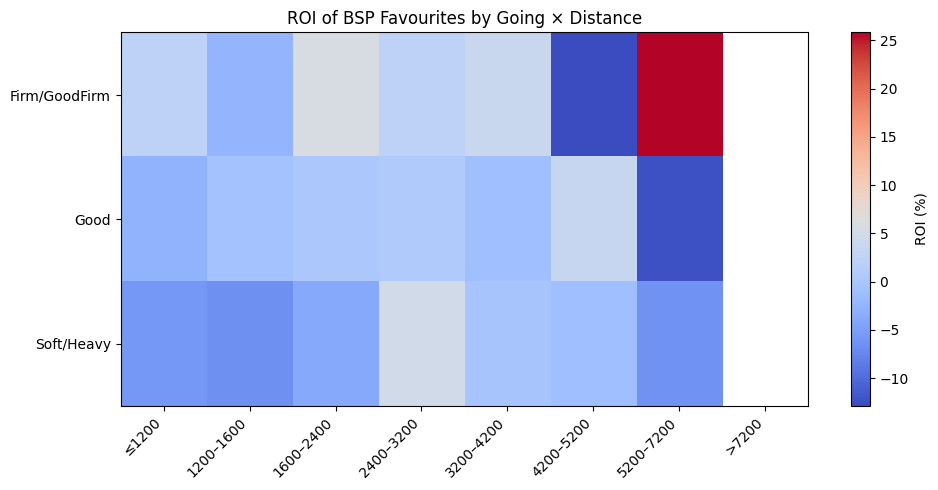

Overall BSP Favourite Win Rate: 34.35%
Overall BSP Favourite ROI per race: -0.25%
ROI (%) by Going × Distance bin:


_dist_bin,≤1200,1200–1600,1600–2400,2400–3200,3200–4200,4200–5200,5200–7200,>7200
_going,,,,,,,,
Firm/GoodFirm,2.37,-2.39,5.59,2.31,3.79,-12.87,25.84,NaN
Good,-2.63,-0.57,0.27,0.72,-0.95,3.34,-12.35,NaN
Soft/Heavy,-5.76,-6.53,-3.82,4.82,-0.26,-0.95,-6.36,NaN


C:\Users\kierb\AppData\Local\Temp\ipykernel_11184\1770157306.py:136: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sign_mat = sign_mat.applymap(lambda x: '+' if pd.notna(x) and x > 0 else '-')


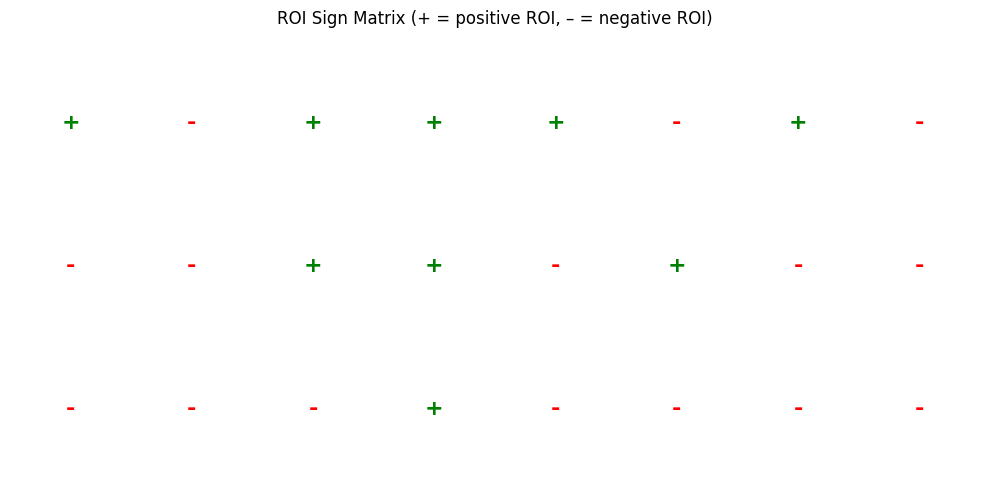

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
BSP_COL = 'obs__bsp'
STAKE = 1.0

# ------------------------------------------------------------
# 1) Clean and robust flags
# ------------------------------------------------------------
w = df.copy()

# Winner flag (either obs__is_winner or obs__uposition)
if 'obs__is_winner' in w.columns:
    win_raw = pd.to_numeric(w['obs__is_winner'], errors='coerce')
    w['_won'] = (win_raw.fillna(0).astype(float) > 0).astype(int)
elif 'obs__uposition' in w.columns:
    up = pd.to_numeric(w['obs__uposition'], errors='coerce')
    w['_won'] = (up == 1).astype(int)
else:
    raise ValueError("Need obs__is_winner or obs__uposition to identify winners.")

# Valid races = exactly one winner
races_with_one_winner = w.groupby('race_id')['_won'].sum()
valid_races = races_with_one_winner[races_with_one_winner == 1].index
w = w[w['race_id'].isin(valid_races)].copy()

# Clean BSP and distance
w['_bsp'] = pd.to_numeric(w[BSP_COL], errors='coerce')
w['_dist'] = pd.to_numeric(w['race_distance'], errors='coerce')

# ------------------------------------------------------------
# 2) Define "going" bins for grouping (simplify surface conditions)
# ------------------------------------------------------------
def going_bin(s):
    if pd.isna(s):
        return 'Unknown'
    s = str(s).lower()
    aw = ['standard','std','std/slow','standard/slow','slow']
    softish = ['good to soft','soft','soft/heavy','heavy','yielding']
    firmish = ['firm','good to firm']
    if any(k in s for k in aw): return 'AW'
    if any(k in s for k in softish): return 'Soft/Heavy'
    if any(k in s for k in firmish): return 'Firm/GoodFirm'
    if 'good' in s: return 'Good'
    return s.title()

w['_going'] = w['going_clean'].apply(going_bin)

# ------------------------------------------------------------
# 3) Create distance bins
# ------------------------------------------------------------
bins = [0, 1200, 1600, 2400, 3200, 4200, 5200, 7200, np.inf]
labels = ['≤1200','1200–1600','1600–2400','2400–3200','3200–4200','4200–5200','5200–7200','>7200']
w['_dist_bin'] = pd.cut(w['_dist'], bins=bins, labels=labels, include_lowest=True)

# ------------------------------------------------------------
# 4) Identify BSP favourite(s) per race
# ------------------------------------------------------------
# Minimum BSP within each race
race_min_bsp = w.groupby('race_id')['_bsp'].transform('min')
w['_is_bsp_fav'] = (w['_bsp'] == race_min_bsp)

# Subset to just BSP favourites (includes joint-favs)
favs = w[w['_is_bsp_fav'] & w['_bsp'].notna() & (w['_bsp'] > 0)].copy()

# ------------------------------------------------------------
# 5) Compute per-race returns (1-unit bet)
# ------------------------------------------------------------
# Win return = BSP - 1, Loss = -1
favs['ret'] = np.where(favs['_won'] == 1, favs['_bsp'] - 1.0, -1.0)

# If multiple joint-favs, share stake equally among them
joint_count = favs.groupby('race_id')['_is_bsp_fav'].transform('sum')
favs['ret'] = favs['ret'] / joint_count  # fractional stake if joint-favs

# ------------------------------------------------------------
# 6) Group and summarise results
# ------------------------------------------------------------
summary = (
    favs.groupby(['_going','_dist_bin'])
        .agg(
            bets=('race_id','nunique'),
            wins=('_won','sum'),
            avg_bsp=('_bsp','mean'),
            roi=('ret','mean')
        )
        .reset_index()
)
summary['win_rate'] = summary['wins'] / summary['bets']
summary['roi_pct'] = summary['roi'] * 100

print("Performance of BSP favourites by Going × Distance bin (1-unit stake per race):")
display(summary.sort_values(['_going','_dist_bin']))

# ------------------------------------------------------------
# 7) Optional heatmap of ROI
# ------------------------------------------------------------
pivot_roi = summary.pivot(index='_going', columns='_dist_bin', values='roi_pct')

plt.figure(figsize=(10,5))
im = plt.imshow(pivot_roi, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.xticks(range(len(pivot_roi.columns)), pivot_roi.columns, rotation=45, ha='right')
plt.yticks(range(len(pivot_roi.index)), pivot_roi.index)
plt.colorbar(im, label='ROI (%)')
plt.title('ROI of BSP Favourites by Going × Distance')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8) Overall summary
# ------------------------------------------------------------
overall_bets = favs['race_id'].nunique()
overall_wins = favs.loc[favs['_won']==1,'race_id'].nunique()
overall_roi = favs['ret'].mean()
print(f"Overall BSP Favourite Win Rate: {overall_wins/overall_bets:.2%}")
print(f"Overall BSP Favourite ROI per race: {overall_roi:.2%}")

# ------------------------------------------------------------
# 9) Simple ROI table
# ------------------------------------------------------------
roi_table = summary.pivot(index='_going', columns='_dist_bin', values='roi_pct')
print("ROI (%) by Going × Distance bin:")
display(roi_table.round(2))

# ------------------------------------------------------------
# 10) Positive / Negative sign matrix visual
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Create sign matrix: + for positive ROI, – for negative/zero or NaN
sign_mat = roi_table.copy()
sign_mat = sign_mat.applymap(lambda x: '+' if pd.notna(x) and x > 0 else '-')

# Plot matrix of symbols
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

# Draw grid manually
n_rows, n_cols = sign_mat.shape
for i, going in enumerate(sign_mat.index):
    for j, dist_bin in enumerate(sign_mat.columns):
        symbol = sign_mat.iloc[i, j]
        color = 'green' if symbol == '+' else 'red'
        ax.text(j, n_rows - i - 1, symbol, ha='center', va='center',
                fontsize=16, color=color, fontweight='bold')

# Add labels
ax.set_xticks(range(n_cols))
ax.set_yticks(range(n_rows))
ax.set_xticklabels(sign_mat.columns, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(sign_mat.index, fontsize=10)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.set_ylim(-0.5, n_rows - 0.5)

plt.title('ROI Sign Matrix (+ = positive ROI, – = negative ROI)', pad=20)
plt.tight_layout()
plt.show()

Filtered races: 8634 (2400–3200 m)
BSP Favourite Performance (2400–3200 m):


,_going,bets,wins,avg_bsp,roi,win_rate,roi_pct
0,Firm/GoodFirm,1085,395,3.174520,0.023131,0.364055,2.313076
1,Good,5672,2050,3.226936,0.007197,0.361425,0.719665
2,Soft/Heavy,1877,719,3.169300,0.048184,0.383058,4.818389


,roi_pct
_going,
Firm/GoodFirm,2.31
Good,0.72
Soft/Heavy,4.82


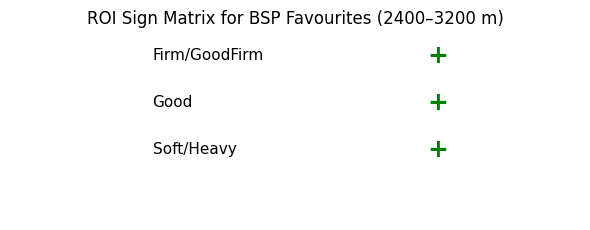

Overall BSP Favourite Win Rate (2400–3200 m): 36.65%
Overall ROI per race: 1.81%


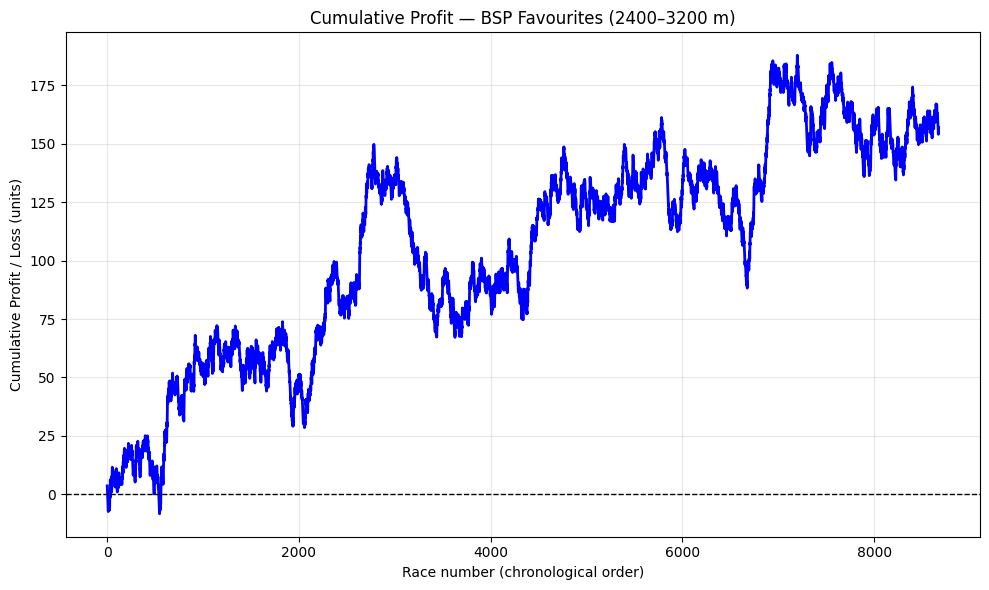

BSP Favourite Win Rate (2400–3200 m): 36.65%
Total Profit: 157.04 units
ROI per bet: 1.81%


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
BSP_COL = 'obs__bsp'
STAKE = 1.0

# ------------------------------------------------------------
# 1) Filter dataset to races 2400–3200 m
# ------------------------------------------------------------
w = df.copy()
w['_dist'] = pd.to_numeric(w['race_distance'], errors='coerce')
w = w[(w['_dist'] >= 2400) & (w['_dist'] <= 3200)].copy()

print(f"Filtered races: {w['race_id'].nunique()} (2400–3200 m)")

# ------------------------------------------------------------
# 2) Build robust winner flag
# ------------------------------------------------------------
if 'obs__is_winner' in w.columns:
    win_raw = pd.to_numeric(w['obs__is_winner'], errors='coerce')
    w['_won'] = (win_raw.fillna(0).astype(float) > 0).astype(int)
elif 'obs__uposition' in w.columns:
    up = pd.to_numeric(w['obs__uposition'], errors='coerce')
    w['_won'] = (up == 1).astype(int)
else:
    raise ValueError("Need obs__is_winner or obs__uposition to identify winners.")

# Keep only races with exactly one winner
races_with_one_winner = w.groupby('race_id')['_won'].sum()
valid_races = races_with_one_winner[races_with_one_winner == 1].index
w = w[w['race_id'].isin(valid_races)].copy()

# ------------------------------------------------------------
# 3) Clean BSP and Going category
# ------------------------------------------------------------
w['_bsp'] = pd.to_numeric(w[BSP_COL], errors='coerce')
w = w[w['_bsp'] > 0].copy()

def going_bin(s):
    if pd.isna(s):
        return 'Unknown'
    s = str(s).lower()
    aw = ['standard','std','std/slow','standard/slow','slow']
    softish = ['good to soft','soft','soft/heavy','heavy','yielding']
    firmish = ['firm','good to firm']
    if any(k in s for k in aw): return 'AW'
    if any(k in s for k in softish): return 'Soft/Heavy'
    if any(k in s for k in firmish): return 'Firm/GoodFirm'
    if 'good' in s: return 'Good'
    return s.title()

w['_going'] = w['going_clean'].apply(going_bin)

# ------------------------------------------------------------
# 4) Identify BSP favourites (lowest BSP per race)
# ------------------------------------------------------------
race_min_bsp = w.groupby('race_id')['_bsp'].transform('min')
w['_is_bsp_fav'] = (w['_bsp'] == race_min_bsp)

favs = w[w['_is_bsp_fav']].copy()

# Split stake equally among joint favourites
joint_fav_count = favs.groupby('race_id')['_is_bsp_fav'].transform('sum')
favs['stake'] = STAKE / joint_fav_count

# ------------------------------------------------------------
# 5) Calculate returns and summarise
# ------------------------------------------------------------
favs['ret'] = np.where(favs['_won'] == 1, favs['_bsp'] - 1.0, -1.0) * favs['stake']

summary = (
        favs.groupby(['_going'])
        .agg(
            bets=('race_id', 'nunique'),
            wins=('_won', 'sum'),
            avg_bsp=('_bsp', 'mean'),
            roi=('ret', 'mean')
        )
        .reset_index()
)
summary['win_rate'] = summary['wins'] / summary['bets']
summary['roi_pct'] = summary['roi'] * 100

# ------------------------------------------------------------
# 6) Display simple ROI table
# ------------------------------------------------------------
print("BSP Favourite Performance (2400–3200 m):")
display(summary[['_going' if c=='_going' else c for c in summary.columns]])

roi_table = summary[['_going' if c=='_going' else c for c in summary.columns if c in ['_going','roi_pct']]]
roi_table = roi_table.set_index('_going')
display(roi_table.round(2))

# ------------------------------------------------------------
# 7) Sign-matrix (simple + / – visual)
# ------------------------------------------------------------
signs = roi_table.copy()
signs['sign'] = signs['roi_pct'].apply(lambda x: '+' if pd.notna(x) and x > 0 else '-')

plt.figure(figsize=(6, 1.5 + 0.3 * len(signs)))
plt.axis('off')
for i, (going, row) in enumerate(signs.iterrows()):
    color = 'green' if row['sign'] == '+' else 'red'
    plt.text(0.5, len(signs) - i - 0.5, row['sign'], ha='center', va='center',
             color=color, fontsize=18, fontweight='bold')
    plt.text(-0.5, len(signs) - i - 0.5, going, ha='left', va='center', fontsize=11)
plt.title('ROI Sign Matrix for BSP Favourites (2400–3200 m)')
plt.xlim(-1, 1)
plt.ylim(-1, len(signs))
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8) Overall stats
# ------------------------------------------------------------
total_bets = favs['race_id'].nunique()
total_wins = favs.loc[favs['_won']==1,'race_id'].nunique()
overall_roi = favs['ret'].mean()
print(f"Overall BSP Favourite Win Rate (2400–3200 m): {total_wins/total_bets:.2%}")
print(f"Overall ROI per race: {overall_roi:.2%}")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Sort favourites chronologically or by race_id ---
if '_ts' in favs.columns:
    favs = favs.sort_values('_ts')
else:
    favs = favs.sort_values('race_id')

# --- Compute cumulative profit ---
favs['cum_pnl'] = favs['ret'].cumsum()
favs['bet_number'] = np.arange(1, len(favs) + 1)

# --- Plot cumulative PnL ---
plt.figure(figsize=(10,6))
plt.plot(favs['bet_number'], favs['cum_pnl'], color='blue', linewidth=2)

plt.title('Cumulative Profit — BSP Favourites (2400–3200 m)')
plt.xlabel('Race number (chronological order)')
plt.ylabel('Cumulative Profit / Loss (units)')
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# --- Optional: summary stats ---
total_bets = favs['race_id'].nunique()
total_wins = favs.loc[favs['_won']==1,'race_id'].nunique()
final_pnl = favs['ret'].sum()
roi = favs['ret'].mean()

print(f"BSP Favourite Win Rate (2400–3200 m): {total_wins/total_bets:.2%}")
print(f"Total Profit: {final_pnl:.2f} units")
print(f"ROI per bet: {roi:.2%}")

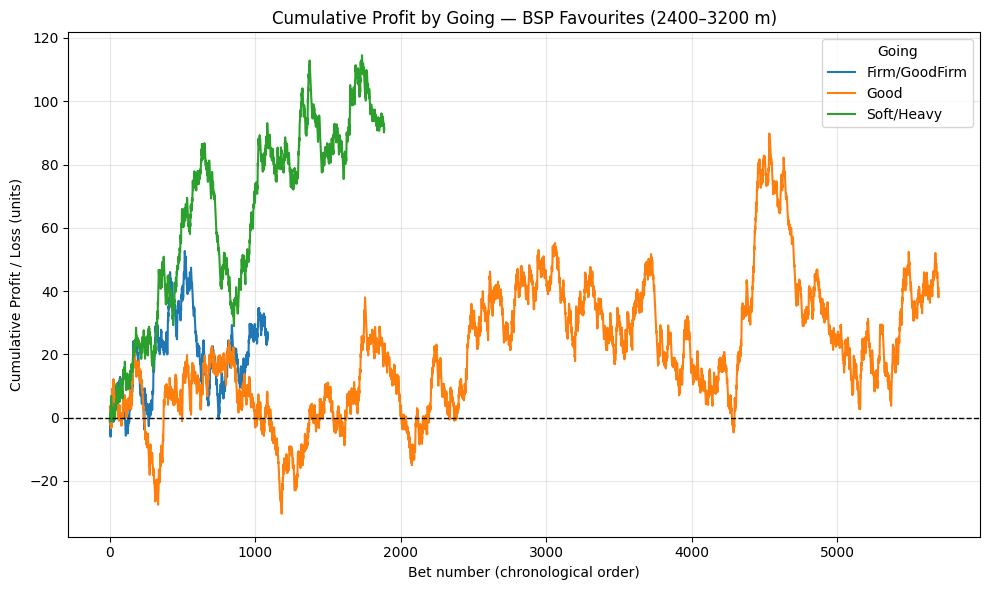

ROI and Volatility by Going Category (2400–3200 m BSP favourites):


,going,bets,total_pnl,roi,volatility,roi_pct,volatility_pct
2,Soft/Heavy,1877,90.923,0.048,1.499,4.818,149.861
0,Firm/GoodFirm,1085,25.120,0.023,1.514,2.313,151.380
1,Good,5672,40.999,0.007,1.492,0.720,149.152


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure favourites DataFrame (favs) is defined and filtered to 2400–3200 m races,
# with columns: race_id, _going, ret, and optionally _ts for timestamps.

# --- 1. Sort chronologically or by race_id ---
if '_ts' in favs.columns:
    favs = favs.sort_values('_ts')
else:
    favs = favs.sort_values('race_id')

# --- 2. Compute cumulative PnL per going category ---
favs['bet_number'] = np.arange(1, len(favs) + 1)

# Compute separate cumulative returns per going
cum_by_going = []
for going, group in favs.groupby('_going'):
    g = group.copy()
    g = g.sort_values('_ts' if '_ts' in g.columns else 'race_id')
    g['cum_pnl'] = g['ret'].cumsum()
    g['bet_number'] = np.arange(1, len(g) + 1)
    g['going'] = going
    cum_by_going.append(g)

cum_df = pd.concat(cum_by_going, ignore_index=True)

# --- 3. Plot cumulative profit per going ---
plt.figure(figsize=(10,6))
for going, group in cum_df.groupby('going'):
    plt.plot(group['bet_number'], group['cum_pnl'], label=going)

plt.title('Cumulative Profit by Going — BSP Favourites (2400–3200 m)')
plt.xlabel('Bet number (chronological order)')
plt.ylabel('Cumulative Profit / Loss (units)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title='Going')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4. Summary table of final ROI and volatility per going ---
summary_roi = (
    cum_df.groupby('going')
    .agg(
        bets=('race_id','nunique'),
        total_pnl=('ret','sum'),
        roi=('ret','mean'),
        volatility=('ret','std')   # <-- standard deviation of returns per bet
    )
    .reset_index()
)
summary_roi['roi_pct'] = summary_roi['roi'] * 100
summary_roi['volatility_pct'] = summary_roi['volatility'] * 100  # easier to interpret in %
summary_roi = summary_roi.sort_values('roi_pct', ascending=False)

print("ROI and Volatility by Going Category (2400–3200 m BSP favourites):")
display(summary_roi.round(3))